# Time series analyzer
## A Climate Asset Pricing model -- AR6 analysis notebook

In this notebook, we provide a smooth framework for users to analyze the output of CAP6. This is meant to be generic analysis, but can be used to make nicer figures; we use it here to make the preferred and featured runs figure in the paper. 

In [1]:
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from src.tree import TreeModel
from src.climate import BPWClimate
from src.emit_baseline import BPWEmissionBaseline
from src.damage import BPWDamage
from src.tools import import_csv
from src.analysis.output_unpacker import OutputUnpacker
from src.analysis.tree_diagrams import TreeDiagram

# plotting parameters
color_list = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'] * 2
marker_list = ['o', 's', 'P', '+', 'D', 'v', '3'] * 2
markersize = 6
linestyle_list = ['solid', 'dashed', 'dashdot', 'dotted'] * 4
linewidth = 2
node_times = [2020, 2030, 2060, 2100, 2150, 2200]
x_label = 'Year'

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
cdds_params={'axes.linewidth': 3,
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'axes.titlesize': 20,
 'axes.labelsize': 20,
 'axes.titlelocation': 'left',
 'figure.facecolor': 'white',
 'figure.figsize': (18, 10),
 'lines.solid_capstyle': 'round',
 'lines.linewidth': 2.5,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'legend.frameon': False,
 'xtick.bottom': True,
 'xtick.major.width': 3,
 'xtick.major.size': 6,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'ytick.color' : 'black',
 'ytick.major.width': 3, 
 'ytick.major.size': 6,
 'axes.prop_cycle': plt.cycler(linestyle=linestyle_list),
 'font.size': 16,
 'font.family': 'serif'}
plt.rcParams.update(cdds_params)

# make base filename
today = datetime.datetime.now()
year = str(today.year)
day = str(today.day)
month = str(today.month)

basefile = ''.join(["/data/keeling/a/adammb4/ClimateEcon/ez-climate/TCREZClimate/docs/figdump/", month, '-', day, '-', year, '-'])

## Make lists of necessary model classes

Make sure this matches the main file! To do this properly, the right classes with the right model parameters need to be initiated. 

In [45]:
"""Import header, indices, and data from reference .csv file.
"""

data_csv_file = 'BPW_research_runs'
header, indices, data = import_csv(data_csv_file, delimiter=',', indices=2)

"""Run TCREZClimate for runs of interest. To change which runs the code does,
change desired_runs.
"""

# runs needing analysis
#done_runs = [275, 276, 277, 278]
done_runs = [275, 293]

tree_list = []
damage_list = []
climate_list = []
emit_baseline_list = []

for i in done_runs:
    ra, eis, pref, growth, tech_chg, tech_scale, dam_func,\
            baseline_num, tip_on, bs_premium, crra_on, d_unc, t_unc, d_var_mult, t_var_mult, nfl = data[i]

    baseline_num = int(baseline_num)
    dam_func = int(dam_func)
    tip_on = int(tip_on)
    crra_on = int(crra_on)
    d_unc = int(d_unc)
    t_unc = int(t_unc)
    nfl = int(nfl)

    """On if CRRA preferences are desired. In our model, this amounts to
    setting RA = 1/EIS. The base case value of EIS is 0.9. If EIS is not
    0.9, then we are doing a sensitivity test of EIS, and therefore the RA is
    determined by the EIS. Otherwise, EIS is determined by RA.
    """

    if crra_on:
        if eis != 0.9:
            ra = eis**(-1)
        else:
            eis = ra**(-1)

    model_params = [ra, eis, pref, growth, tech_chg, tech_scale,\
                    dam_func, baseline_num, tip_on, bs_premium, crra_on, d_unc,
                    t_unc, d_var_mult, t_var_mult, nfl]

    """Initialize model classes. First is the tree model.
    """

    tmp_tree = TreeModel(decision_times=[0, 10, 40, 80, 130, 180, 230],
                  prob_scale=1.0)

    """Emission baseline model. We also run its setup function.
    """

    tmp_baseline_emission_model = BPWEmissionBaseline(tree=tmp_tree,
                                                  baseline_num=baseline_num)
    tmp_baseline_emission_model.baseline_emission_setup()

    """Climate class. We set draws to the number of Monte Carlo samples to take
    from damage distributions, such as TCRE, and if the floor is on.
    """

    draws = 3 * 10**6
    tmp_climate = BPWClimate(tmp_tree, tmp_baseline_emission_model, draws=draws, t_var_mult=t_var_mult)

    """Damage class. We set draws to the number of Monte Carlo samples to take
    from damage distributions, such as TCRE. We also pass a list of constant
    values of mitigation for the damage simulation.
    """

    d_m = 0.01
    mitigation_constants = np.arange(0, 1 + d_m, d_m)[::-1]
    tmp_df = BPWDamage(tree=tmp_tree, emit_baseline=tmp_baseline_emission_model,
                   climate=tmp_climate, mitigation_constants=mitigation_constants,
                   draws=draws)

    """Run the damage simulation. If a damage simulation has already been run,
    then comment the line below and uncomment the df.import_damages() line.

    NOTE: import_damages has the optional argument for a filename. This is
    important if you're varying the damage function across simulations.

    The default is currently "BPW_simulated_damages_TCRE.csv".
    """

    damsim_filename = ''.join(["BPW_simulated_damages_df", str(dam_func),
                               "_TP", str(tip_on), "_SSP", str(baseline_num),
                               "_dunc", str(d_unc), "_tunc", str(t_unc), "_dmult", str(d_var_mult),
                              "_tmult", str(t_var_mult)])

    tmp_df.import_damages(file_name=damsim_filename)
    
    tree_list.append(tmp_tree)
    emit_baseline_list.append(tmp_baseline_emission_model)
    climate_list.append(tmp_climate)
    damage_list.append(tmp_df)

Damages imported successfully!
Damages imported successfully!


## Make list of files of interest

Here we make lists of file prefixes (i.e., whatever the `name` parameter was when the simulation was executed) and paths. We take the list of paths and prefixes and make lists of filenames, which will be passed to `OutputUnpacker` later.

In [48]:
# list of prefixes to output files of EZClimate. i.e., the string before "_node_period_output.csv".
# in EZClimate main file, this is the parameter "name" located at about line 42 

# prefixes ("name" variable in main file)
#prefix_list = ['pref-run', 'feat-15', 'feat-25', 'feat-3']
prefix_list = ['pref-run', 'pref-run-nfl']

# path to data, in order of the prefixes listed above
path_list = ['/data/keeling/a/adammb4/ClimateEcon/ez-climate/TCREZClimate/data/'] * len(prefix_list) 

# file description - this will be used in plot titles and helps keep track of which file is which
# in the prefix_list
#descriptions = ['2% discount rate', '1.5% discount rate', '2.5% discount rate', '3% discount rate']
descriptions = ['2% discount rate', '2% discount rate, NFL']


# make list of file names to be unpacked
output_list = []
picklefile_list = []

# total files
N_files = len(prefix_list)

# populate output_list and picklefile_list
for file in range(0, N_files):
    tmp_filename = path_list[file] + prefix_list[file] + "_node_period_output.csv"
    tmp_picklefile_name = path_list[file] + prefix_list[file] + "_log.pickle"
    output_list.append(tmp_filename)
    picklefile_list.append(tmp_picklefile_name)

In [49]:
# use OutputUnpacker to "unpack" the files above

# make one array of objects which correspond to the 'output' files (i.e., the files that end with
# _node_period_output.csv) and another for the pickle files
output_obj_list = []
pickle_obj_list = []

# populate these arrays
for file in range(0, N_files):
    tmp_output_obj = OutputUnpacker(output_list[file], descriptions[file], 'output', 
                                    tree=tree_list[file], emit_baseline=emit_baseline_list[file],
                                    climate=climate_list[file], damage=damage_list[file])
    output_obj_list.append(tmp_output_obj)
    tmp_pickle_obj = OutputUnpacker(picklefile_list[file], descriptions[file], 'pickle',
                                    tree=tree_list[file], emit_baseline=emit_baseline_list[file],
                                    climate=climate_list[file], damage=damage_list[file])
    pickle_obj_list.append(tmp_pickle_obj)

## SAVE FIGS?!

In [50]:
save_fig = False
fig_filename_prefix = 'ra-impact'

## Time series plots

Here we plot a number of time series of key model variables, such as:
- average mitigation
- expected mitigation
- average temperature
- average emissions
- cost of carbon
- CO$_2$ concentrations
- economic damages

In [51]:
output_obj_list[1].price_node

array([2.54600746e+02, 2.35270934e+02, 1.28167149e+02, 1.75940580e+02,
       8.93418503e+01, 1.09780322e+02, 4.34080017e+01, 8.66671107e+01,
       4.24696992e+01, 5.51315304e+01, 5.70338274e+01, 1.89328427e+01,
       2.14285377e+01, 2.48808592e+01, 8.38338226e+00, 7.38106340e+01,
       3.48490853e+01, 3.54462579e+01, 5.65130351e+01, 5.18976592e+01,
       1.57109816e+01, 1.66267031e+01, 1.71531074e+01, 1.92237133e+01,
       1.91456053e+01, 2.39444522e+01, 5.71982610e+00, 7.56687817e+00,
       6.41341952e+00, 8.12802635e+00, 2.07020641e+00, 3.84800750e+01,
       3.43902159e+01, 2.99670904e+01, 2.92479639e+01, 3.22086939e+01,
       2.79332665e+01, 1.24368309e+01, 1.54371543e+01, 1.42831246e+01,
       1.23549563e+01, 1.07772096e+01, 1.33857039e+01, 1.50693990e+01,
       1.43823115e+01, 1.61937587e+01, 1.47403477e+01, 5.81065261e+00,
       5.04368770e+00, 4.98744573e+00, 3.91650413e+00, 5.88983408e+00,
       7.50430509e+00, 8.39016202e+00, 5.12652261e+00, 6.37544059e+00,
      

### Cost of carbon

227.77808252150024
254.60074583767803


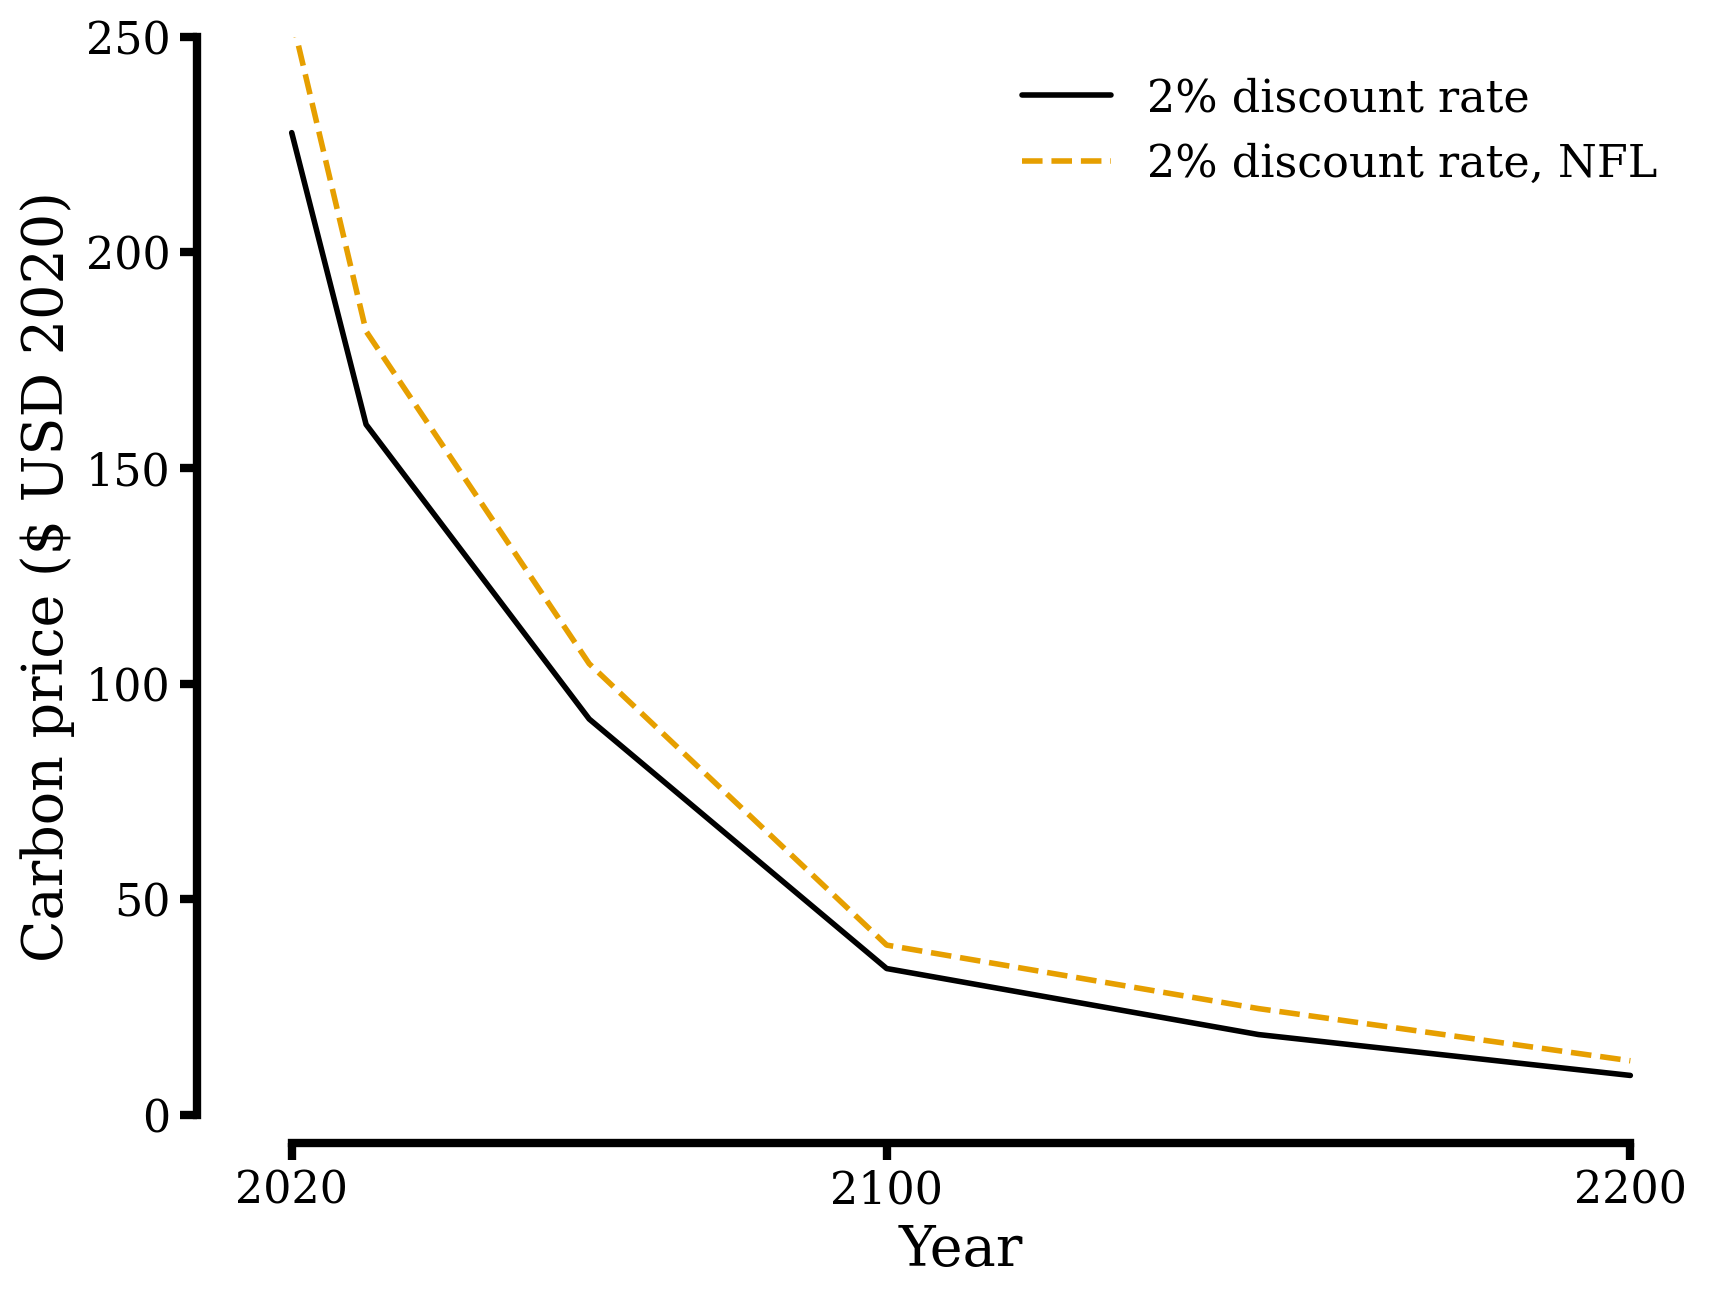

In [52]:
fig, ax = plt.subplots(1, figsize=(9.5,7))

for file in range(0, N_files):
    ax.plot(node_times, np.mean(output_obj_list[file].price_path, axis=0), 
                  color=color_list[file], marker=None, 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)
    print(np.mean(output_obj_list[file].price_path, axis=0)[0])


ax.set_ylabel("Carbon price ($ USD 2020)")
ax.legend()
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim((0,250))
ax.set_yticks([0,50, 100,150, 200, 250])
ax.set_xticks([2020, 2100, 2200])
sns.despine(trim=True, offset=10)

if save_fig:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-cost.png']), dpi=400)

### Average mitigation

In [9]:
np.mean(pickle_obj_list[0].m_opt_path, axis=0)

array([0.67664371, 0.60290872, 0.55624001, 0.43253843, 0.48640401,
       0.5022166 ])

In [10]:
pickle_obj_list[1].m_opt_node[32:]

array([9.91664494e-01, 9.43452763e-01, 9.83715192e-01, 9.80036982e-01,
       9.92926863e-01, 7.16597532e-01, 7.86038523e-01, 7.15412471e-01,
       6.94545686e-01, 8.73214945e-01, 7.99115785e-01, 8.24139101e-01,
       8.71097669e-01, 9.55572182e-01, 9.41900475e-01, 5.36427910e-02,
       1.00000000e-05, 1.02900809e-01, 4.89857921e-01, 2.26077676e-01,
       4.72375080e-01, 4.53869192e-01, 3.29212187e-01, 3.96277350e-01,
       6.20424495e-01, 1.13480046e-01, 6.53806651e-02, 1.00000000e-05,
       2.20827893e-01, 2.11845941e-01, 4.79224600e-02])

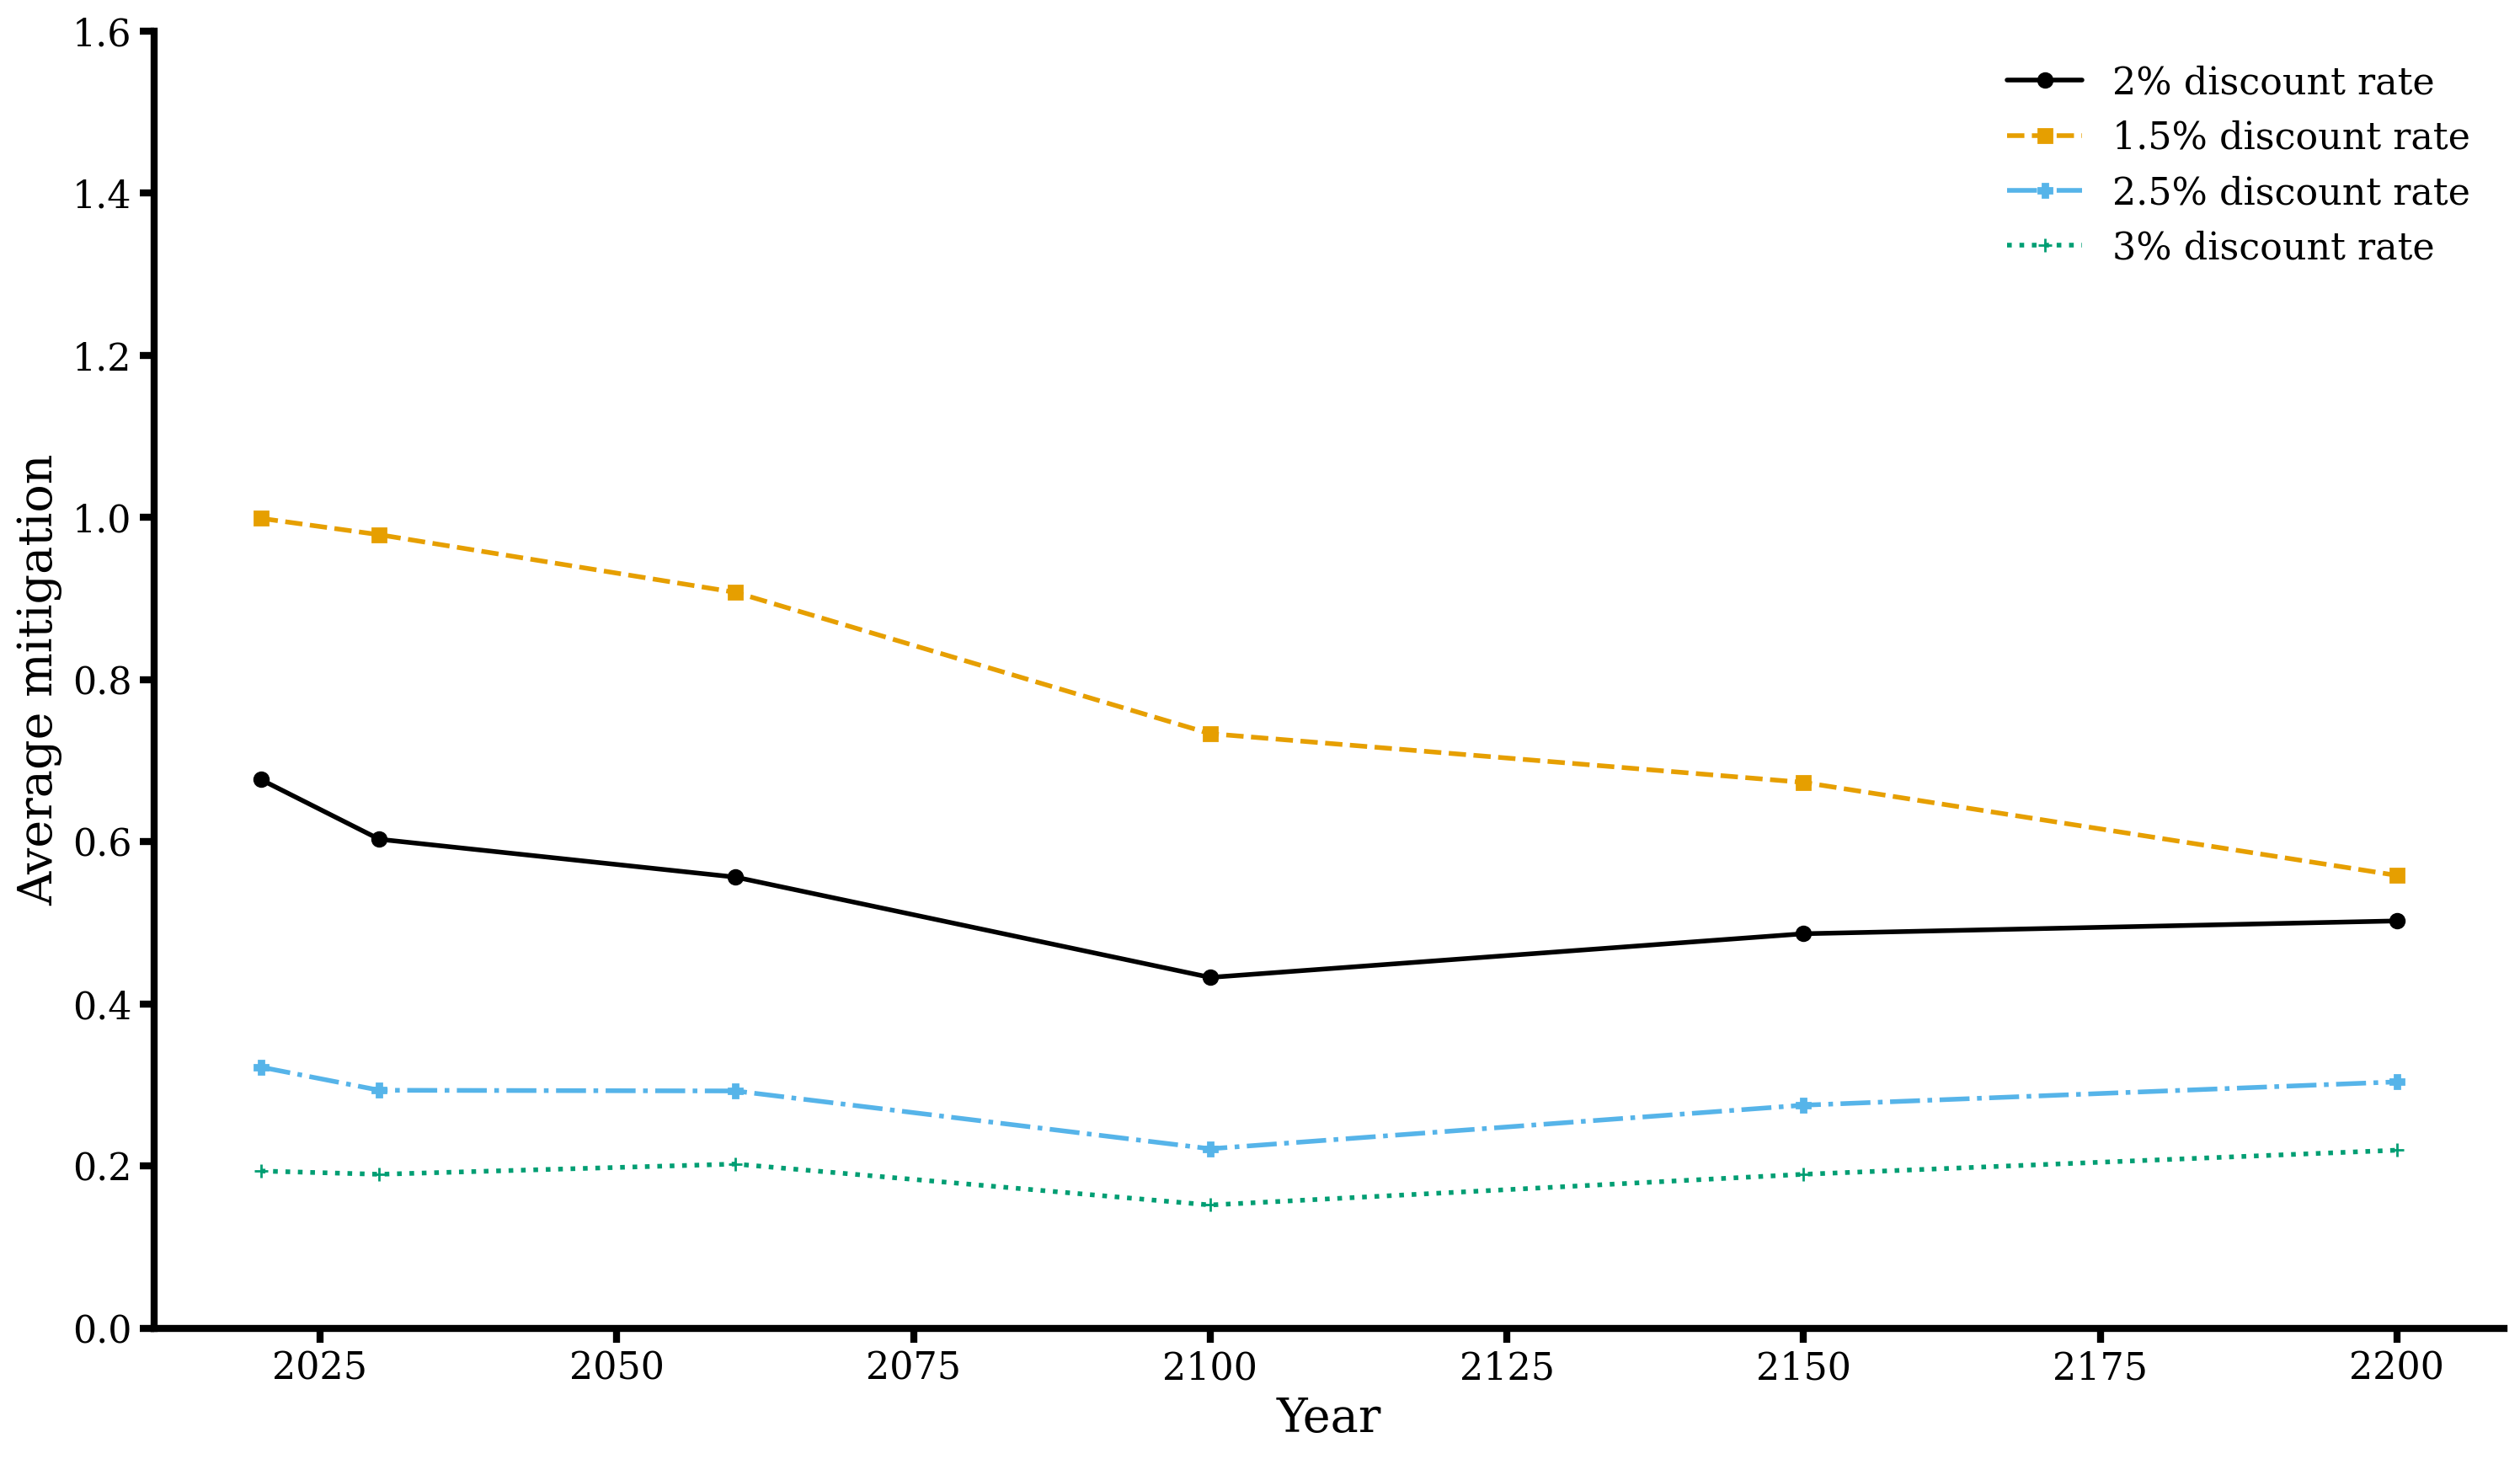

In [11]:
fig, ax = plt.subplots(1)

for file in range(0, N_files):
    ax.plot(node_times, np.mean(pickle_obj_list[file].m_opt_path, axis=0), 
            color=color_list[file], marker=marker_list[file], 
            label=pickle_obj_list[file].description, markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average mitigation")
ax.legend()
ax.set_xlabel(x_label)
ax.tick_params(axis='both')
#ax.axhline(1, color='g', linestyle='dashed')
ax.set_ylim((0,1.6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if save_fig:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-mit.png']), dpi=400)

### Expected mitigation

Difference from average, as this is the weighted average of mitigation

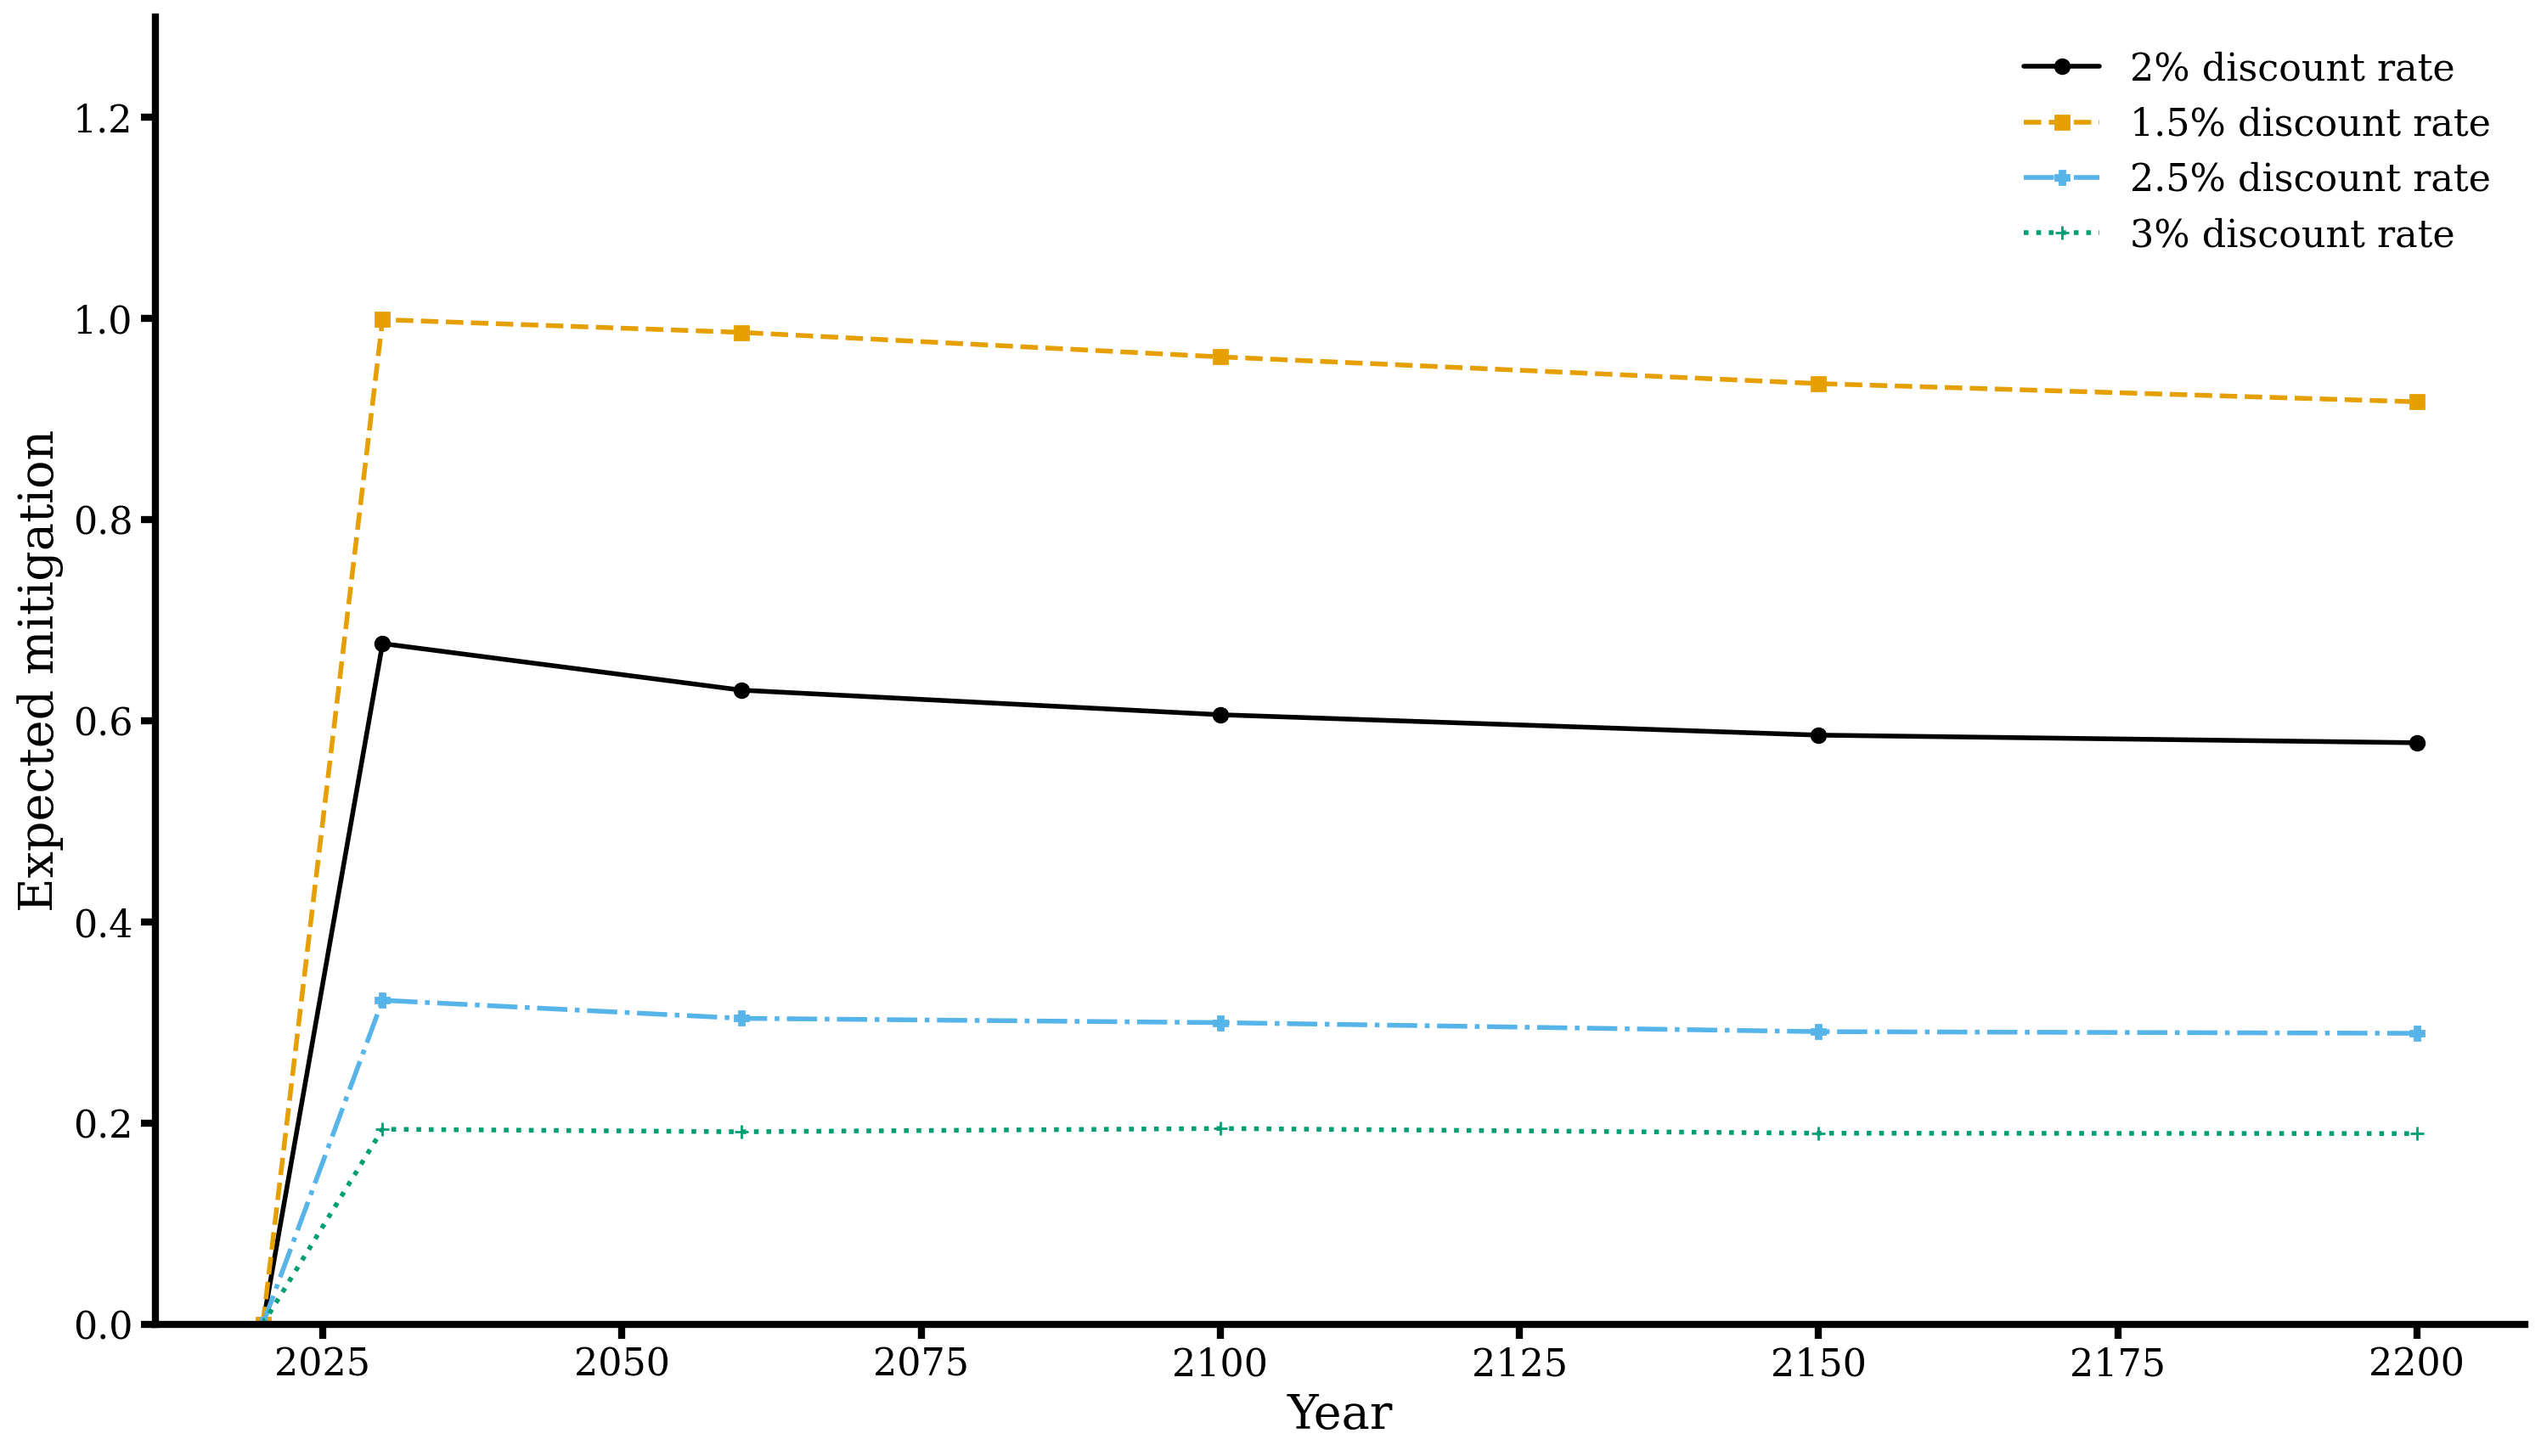

In [12]:
fig, ax = plt.subplots()

for file in range(0, N_files):
    ax.plot(node_times, np.mean(output_obj_list[file].exp_mit_path, axis=0), 
            color=color_list[file], marker=marker_list[file], 
            label=pickle_obj_list[file].description, markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Expected mitigation")
ax.legend()
ax.set_xlabel(x_label)
#ax.axhline(1, color='g', linestyle='dashed')
ax.set_ylim((0,1.3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if save_fig:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-exp-mit.png']), dpi=400)

### (Mitigated) emissions

In [13]:
pickle_obj_list[0].emis_gtco2_full[0:2, :]

array([[13.1436348 , 14.05825806, 13.20340824, 12.9674902 , 11.99312592,
         8.48012733,  6.45920324,  3.92879868,  2.33037806,  2.50838733,
         2.32921672,  2.15004635,  1.97087574,  1.79170525,  0.33137041,
         0.29455146,  0.25773254,  0.2209136 ,  0.18409467],
       [13.1436348 , 14.05825806, 13.20340824, 12.9674902 , 11.99312592,
         8.48012733,  6.45920324,  3.92879868,  2.33037806,  2.50838733,
         2.32921672,  2.15004635,  1.97087574,  1.79170525,  0.33137041,
         0.29455146,  0.25773254,  0.2209136 ,  0.18409467]])

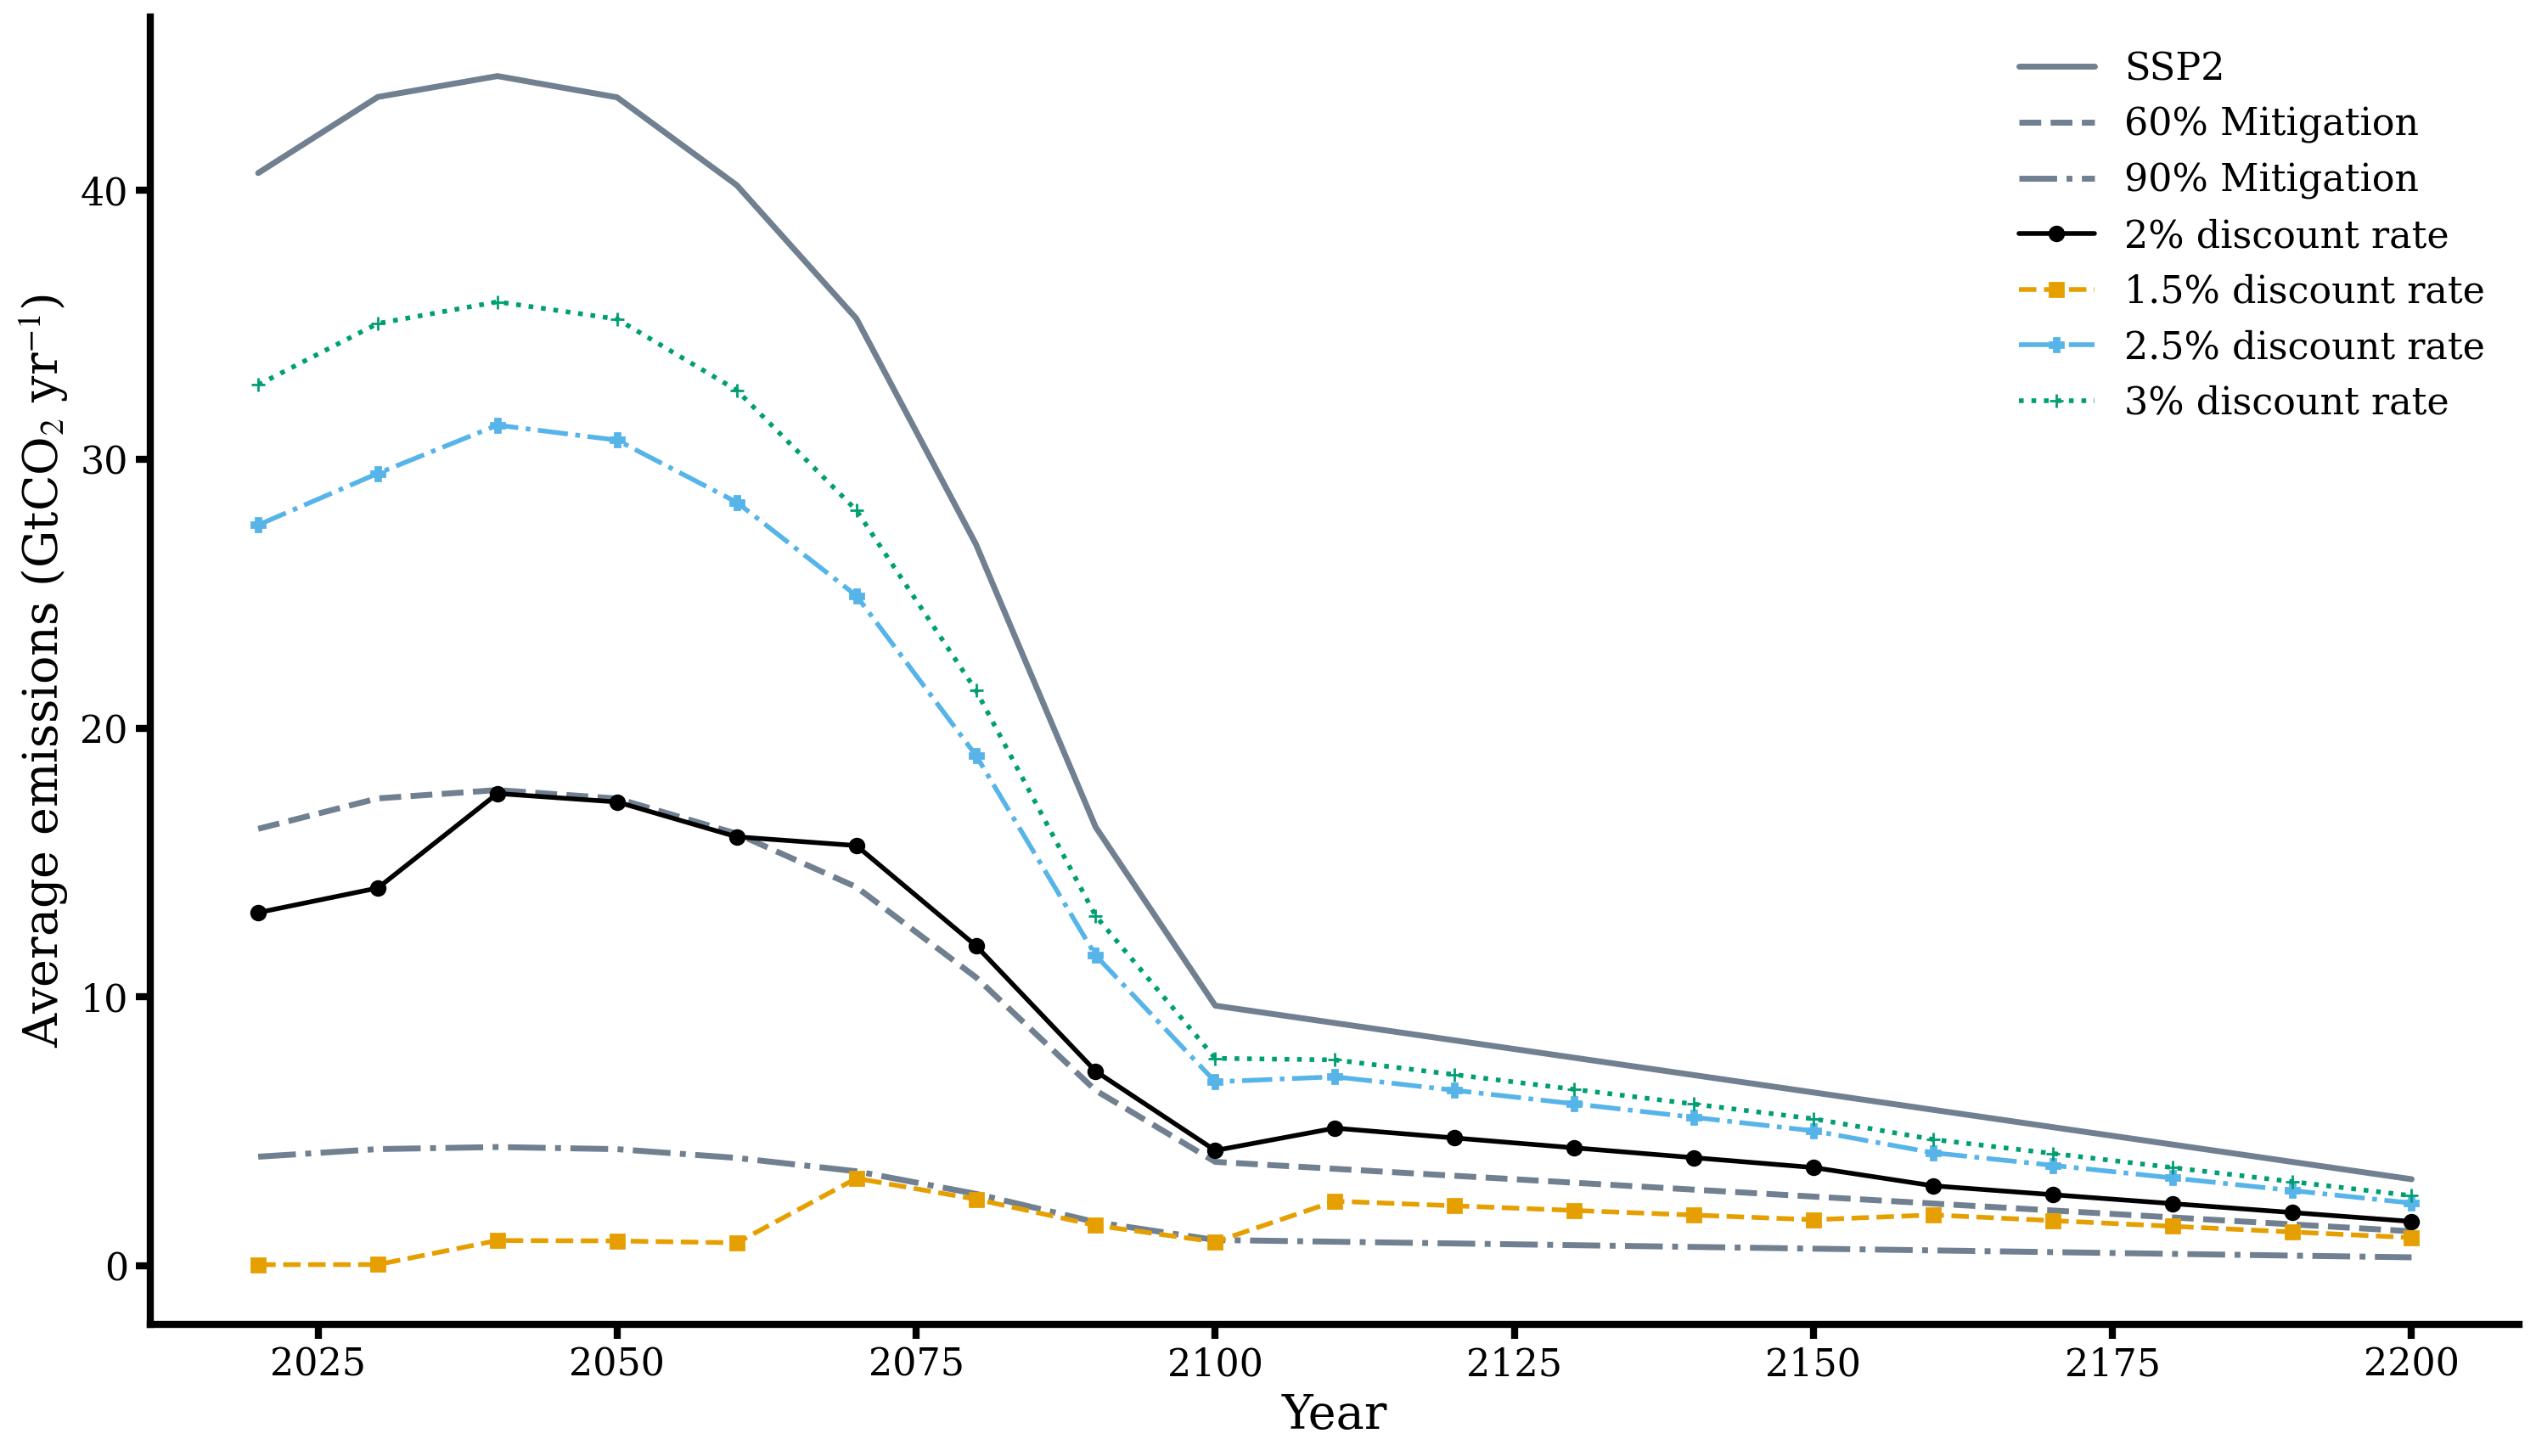

In [14]:
fig, ax = plt.subplots()

ax.plot(tmp_baseline_emission_model.times[:-5], tmp_baseline_emission_model.baseline_gtco2[:-5], 
        color='slategrey', label="SSP2")
ax.plot(tmp_baseline_emission_model.times[:-5], (1 - 0.6) * tmp_baseline_emission_model.baseline_gtco2[:-5], 
        color='slategrey', label="60% Mitigation", linestyle="dashed")
ax.plot(tmp_baseline_emission_model.times[:-5], (1 - 0.9) * tmp_baseline_emission_model.baseline_gtco2[:-5], 
        color='slategrey', label="90% Mitigation", linestyle="dashdot")

for file in range(0, N_files):
    ax.plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].emis_gtco2_full, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

    
ax.set_ylabel("Average emissions (GtCO$_2$ yr$^{-1}$)")
ax.set_xlabel(x_label)
ax.legend()

### Average temperature

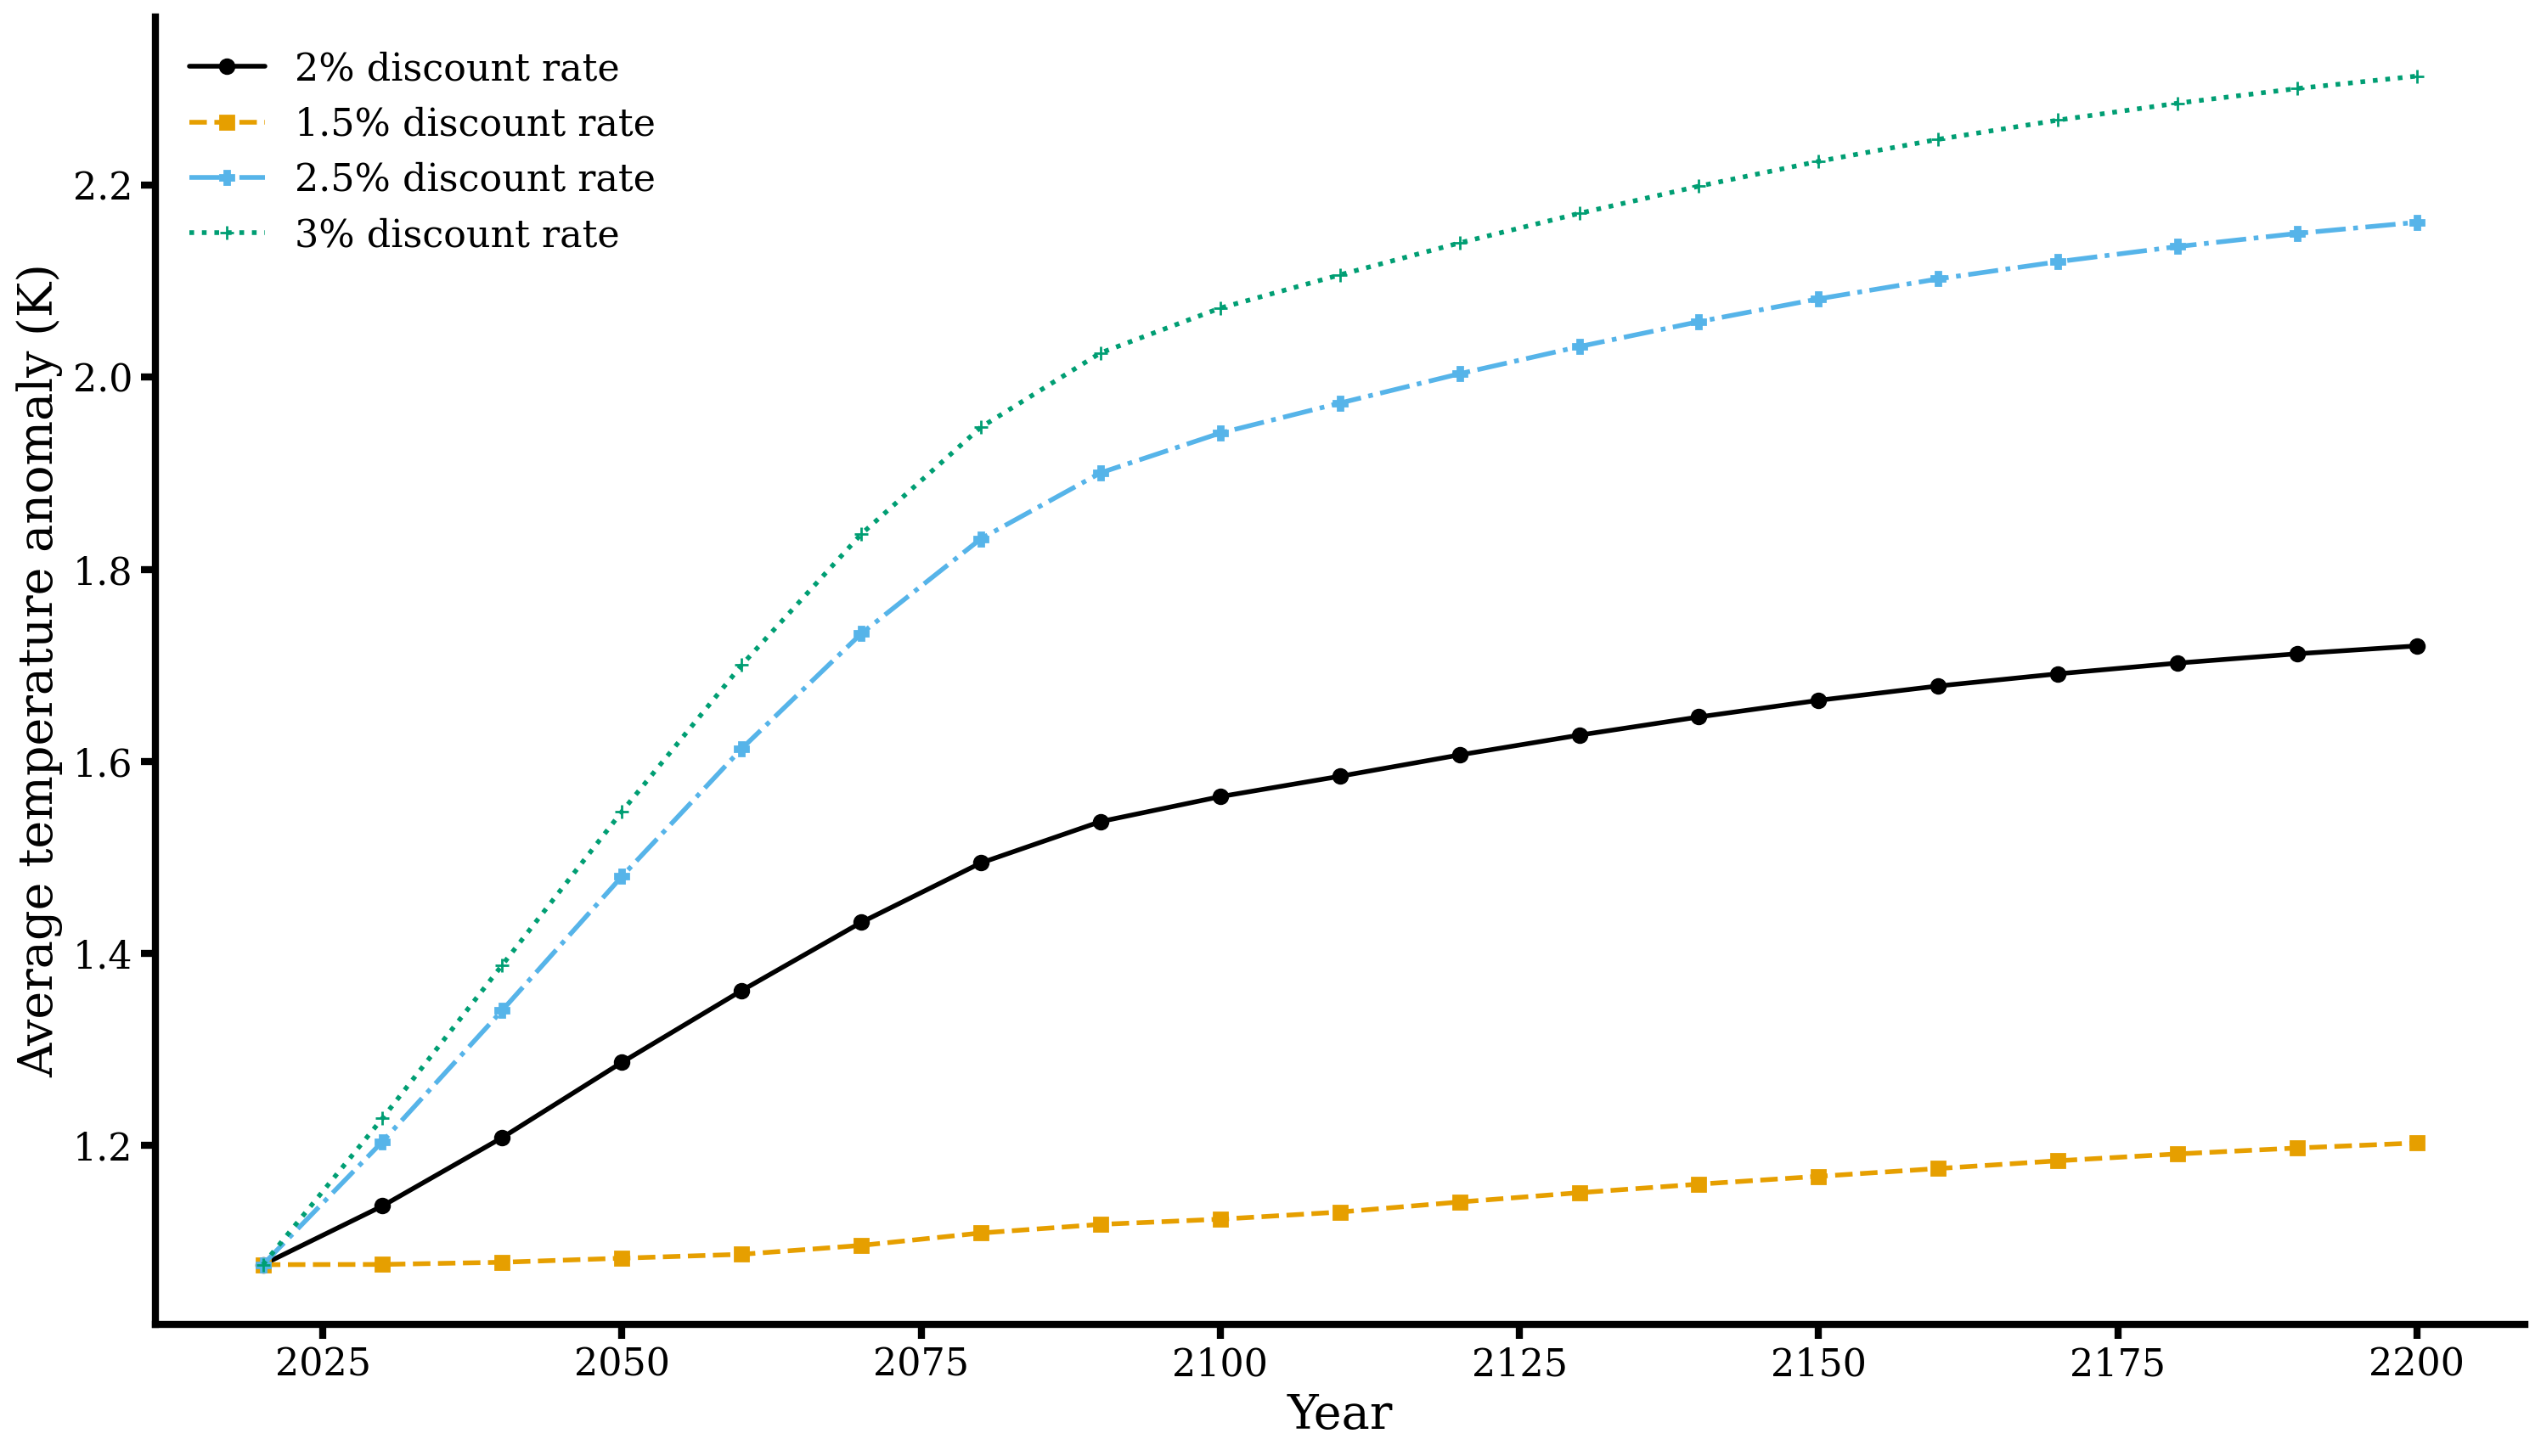

In [15]:
fig, ax = plt.subplots()

for file in range(0, N_files):
    ax.plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].temp_full, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

    
ax.set_ylabel("Average temperature anomaly (K)")
ax.legend()
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim((0,5))

if save_fig:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-temp.png']), dpi=400)

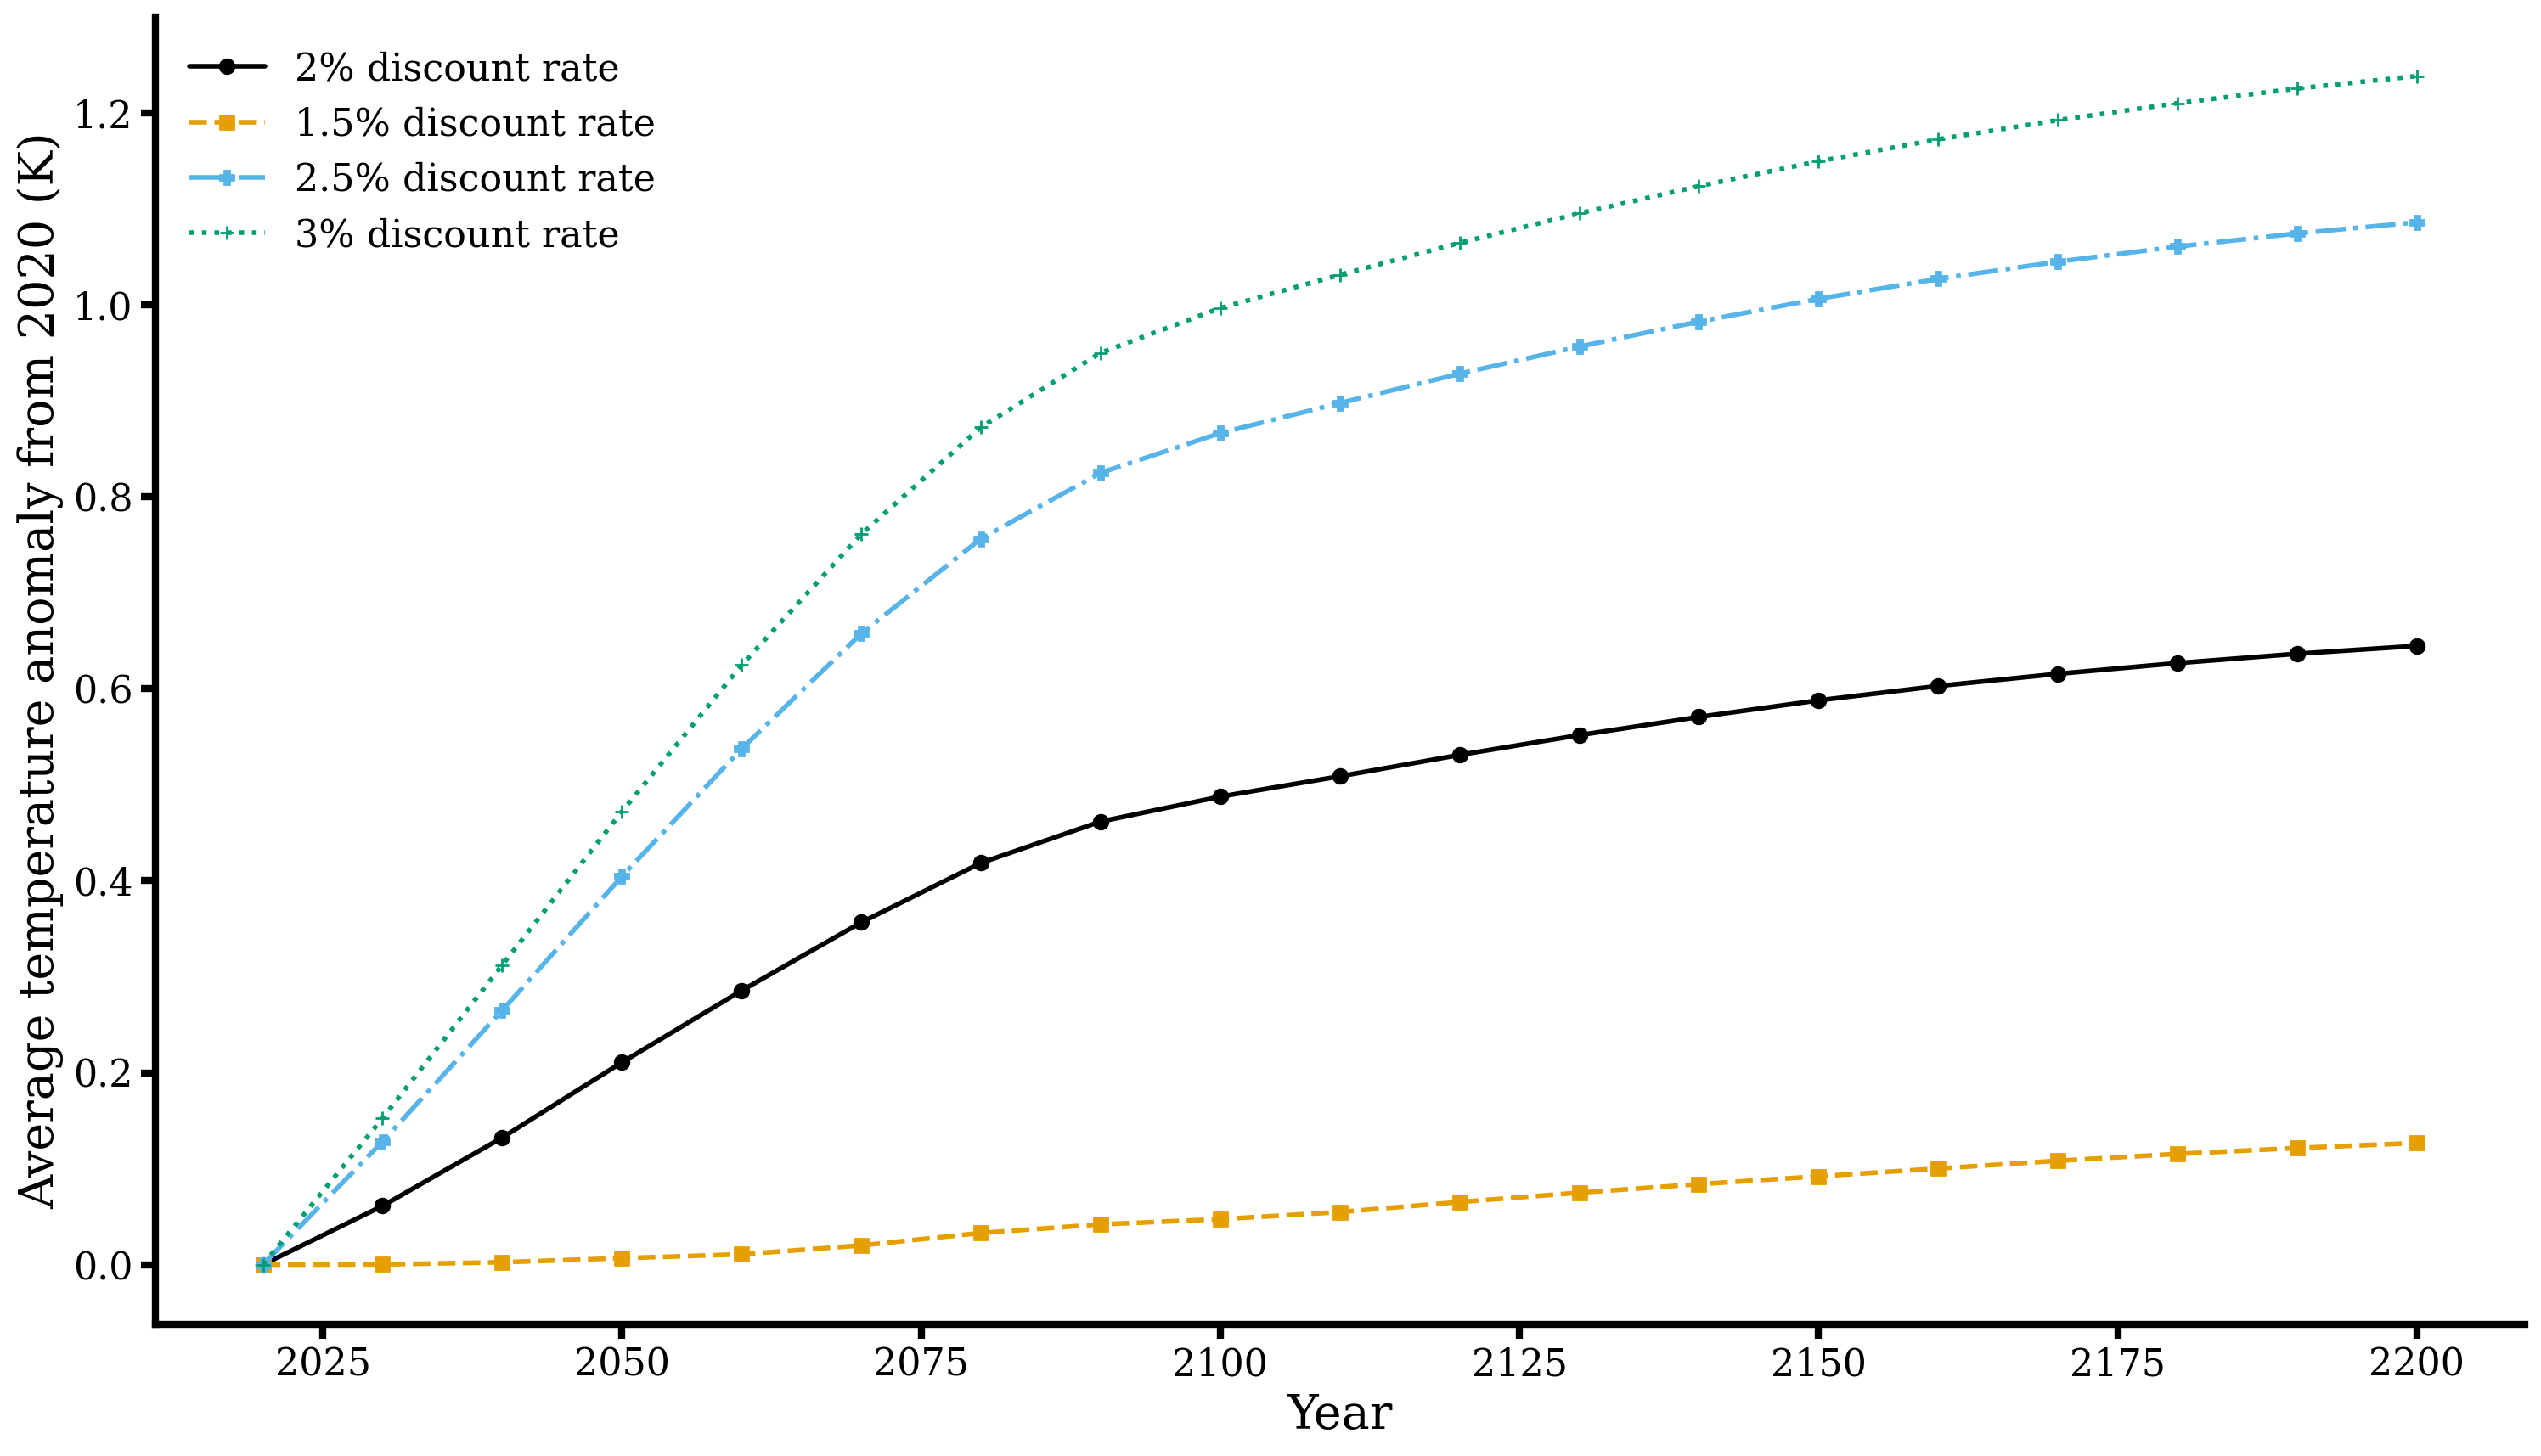

In [16]:
fig, ax = plt.subplots(1)

for file in range(0, N_files):
    ax.plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].temp_full, axis=0) - np.mean(pickle_obj_list[file].temp_full, axis=0)[0], 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

    
ax.set_ylabel("Average temperature anomaly from 2020 (K)")
ax.legend()
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### CO$_2$ concentrations

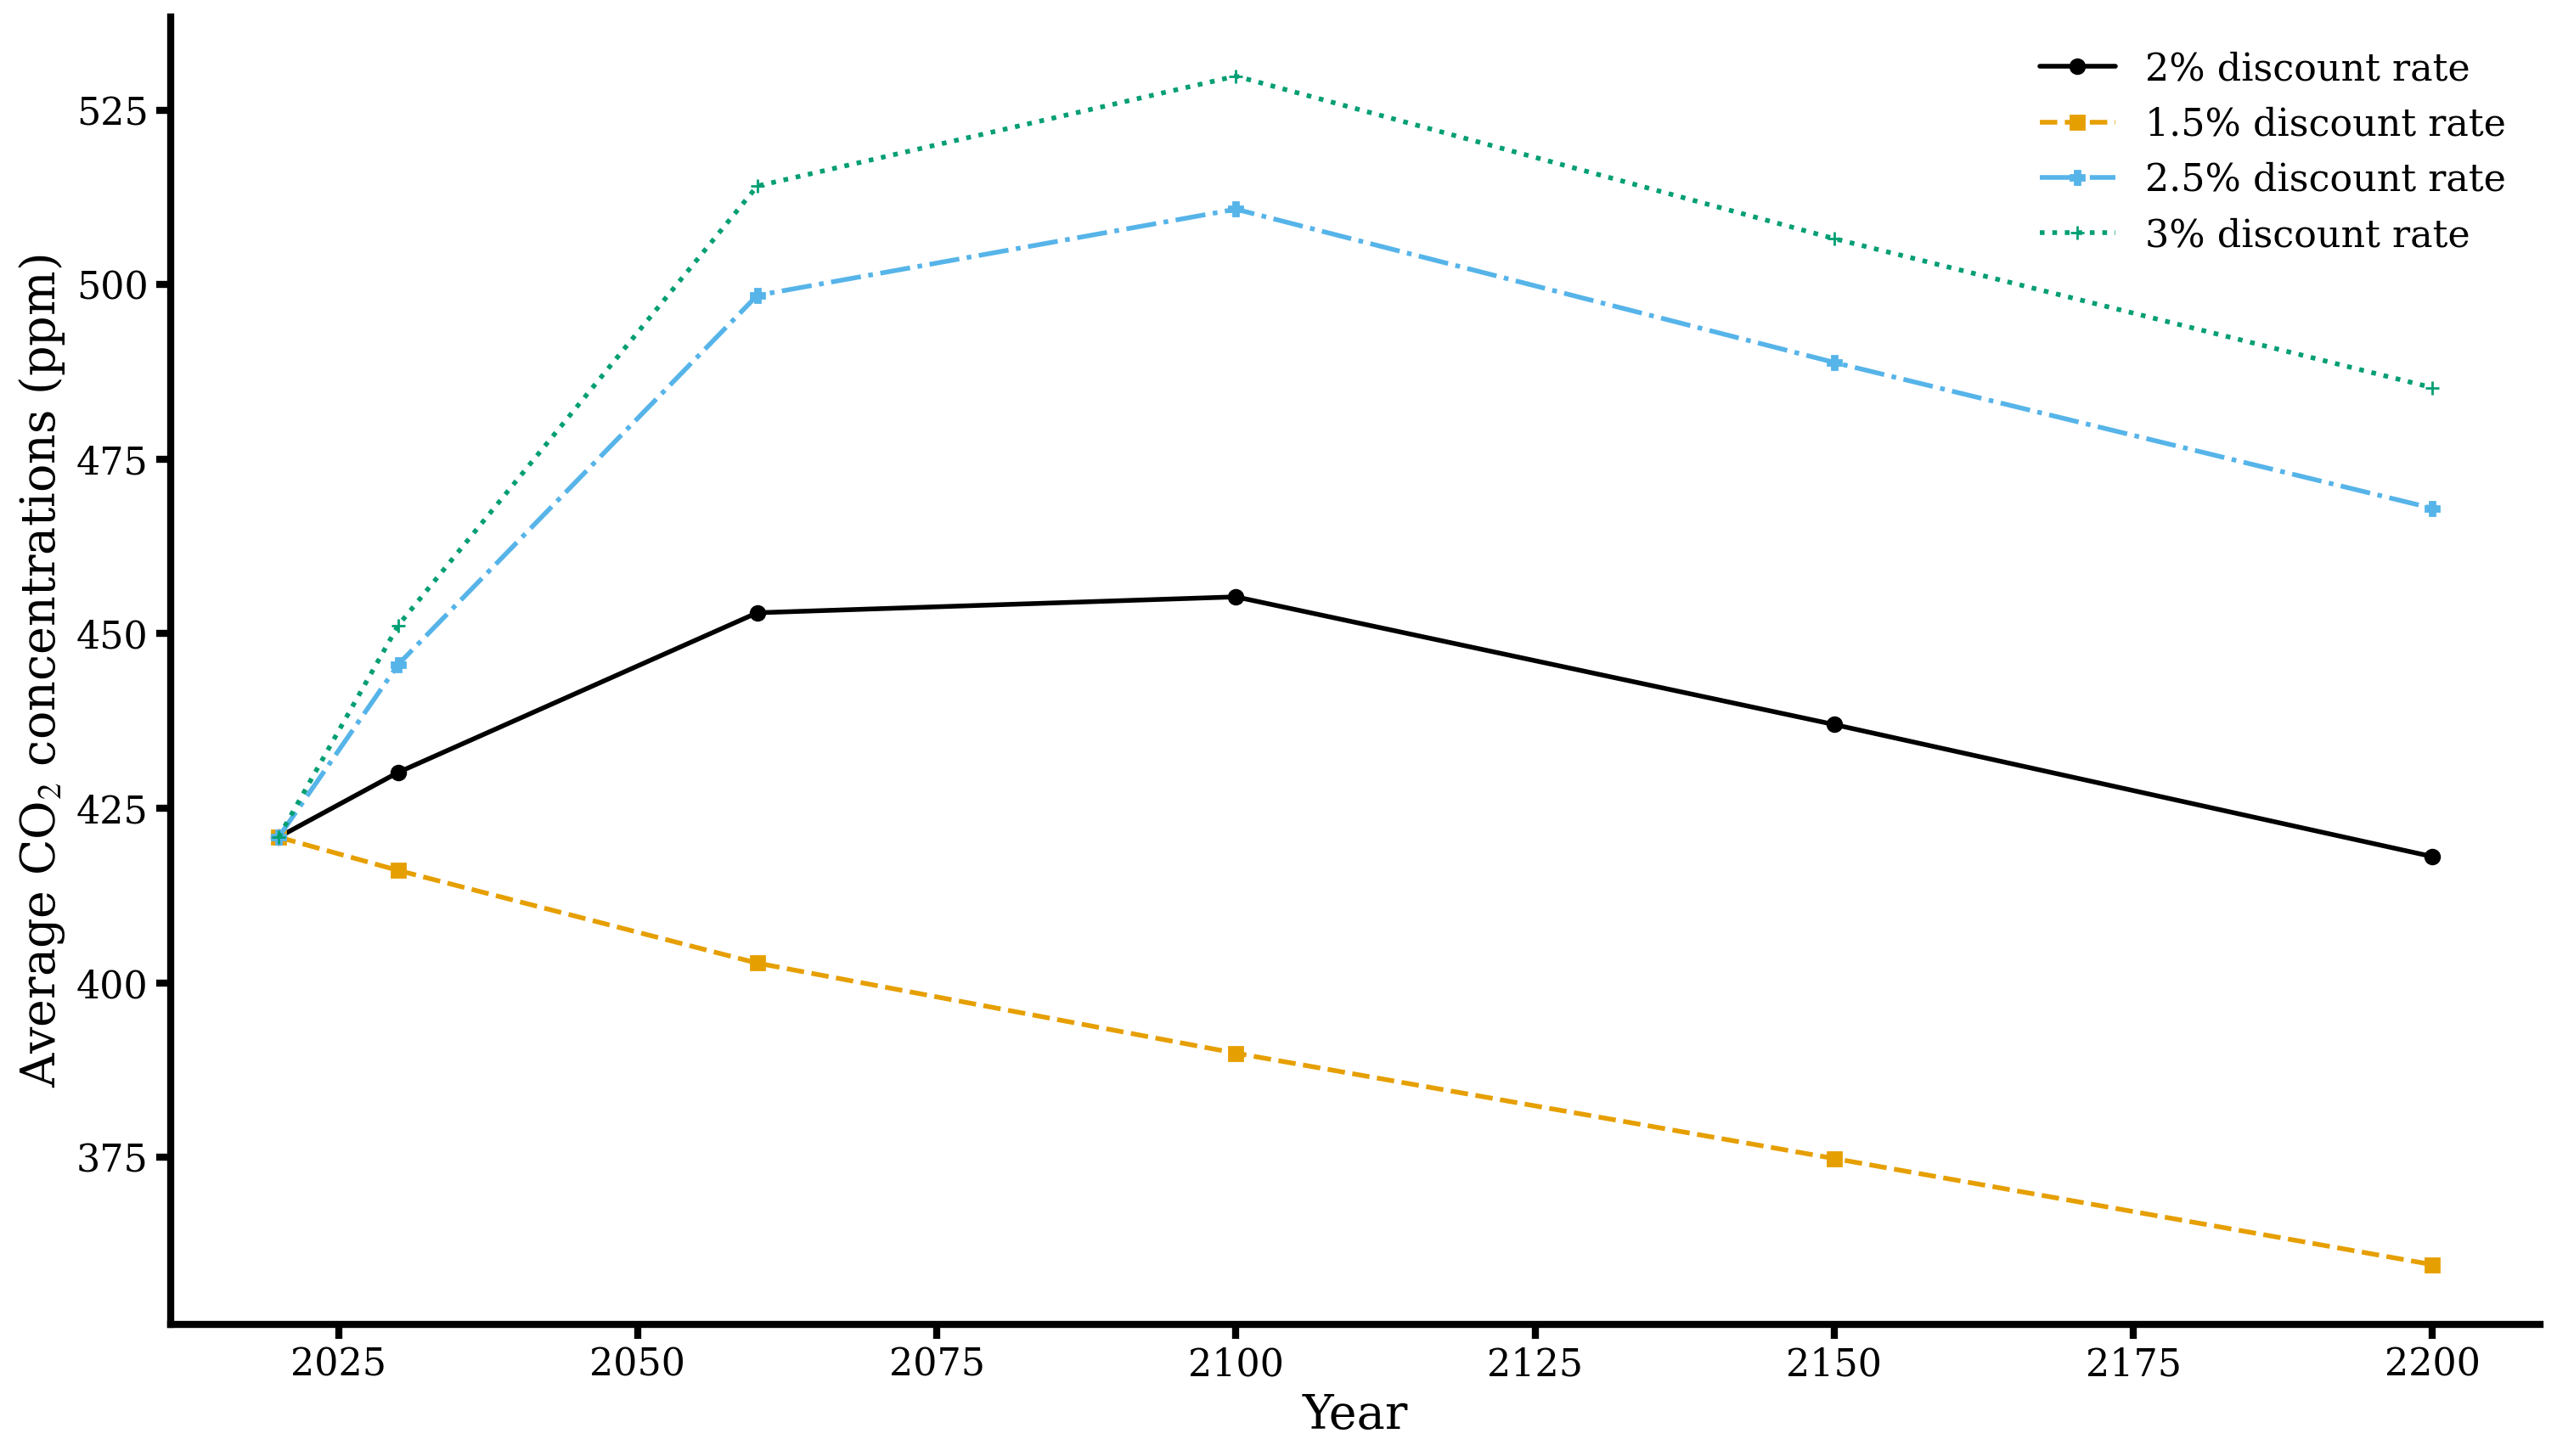

In [17]:
fig, ax = plt.subplots()

for file in range(0, N_files):
    ax.plot(node_times, np.mean(output_obj_list[file].ghg_lvl_path, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)


ax.set_ylabel("Average CO$_2$ concentrations (ppm)")
ax.legend()
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if save_fig:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-co2.png']), dpi=400)

### Economic damages

Text(0.5, 0, 'Year')

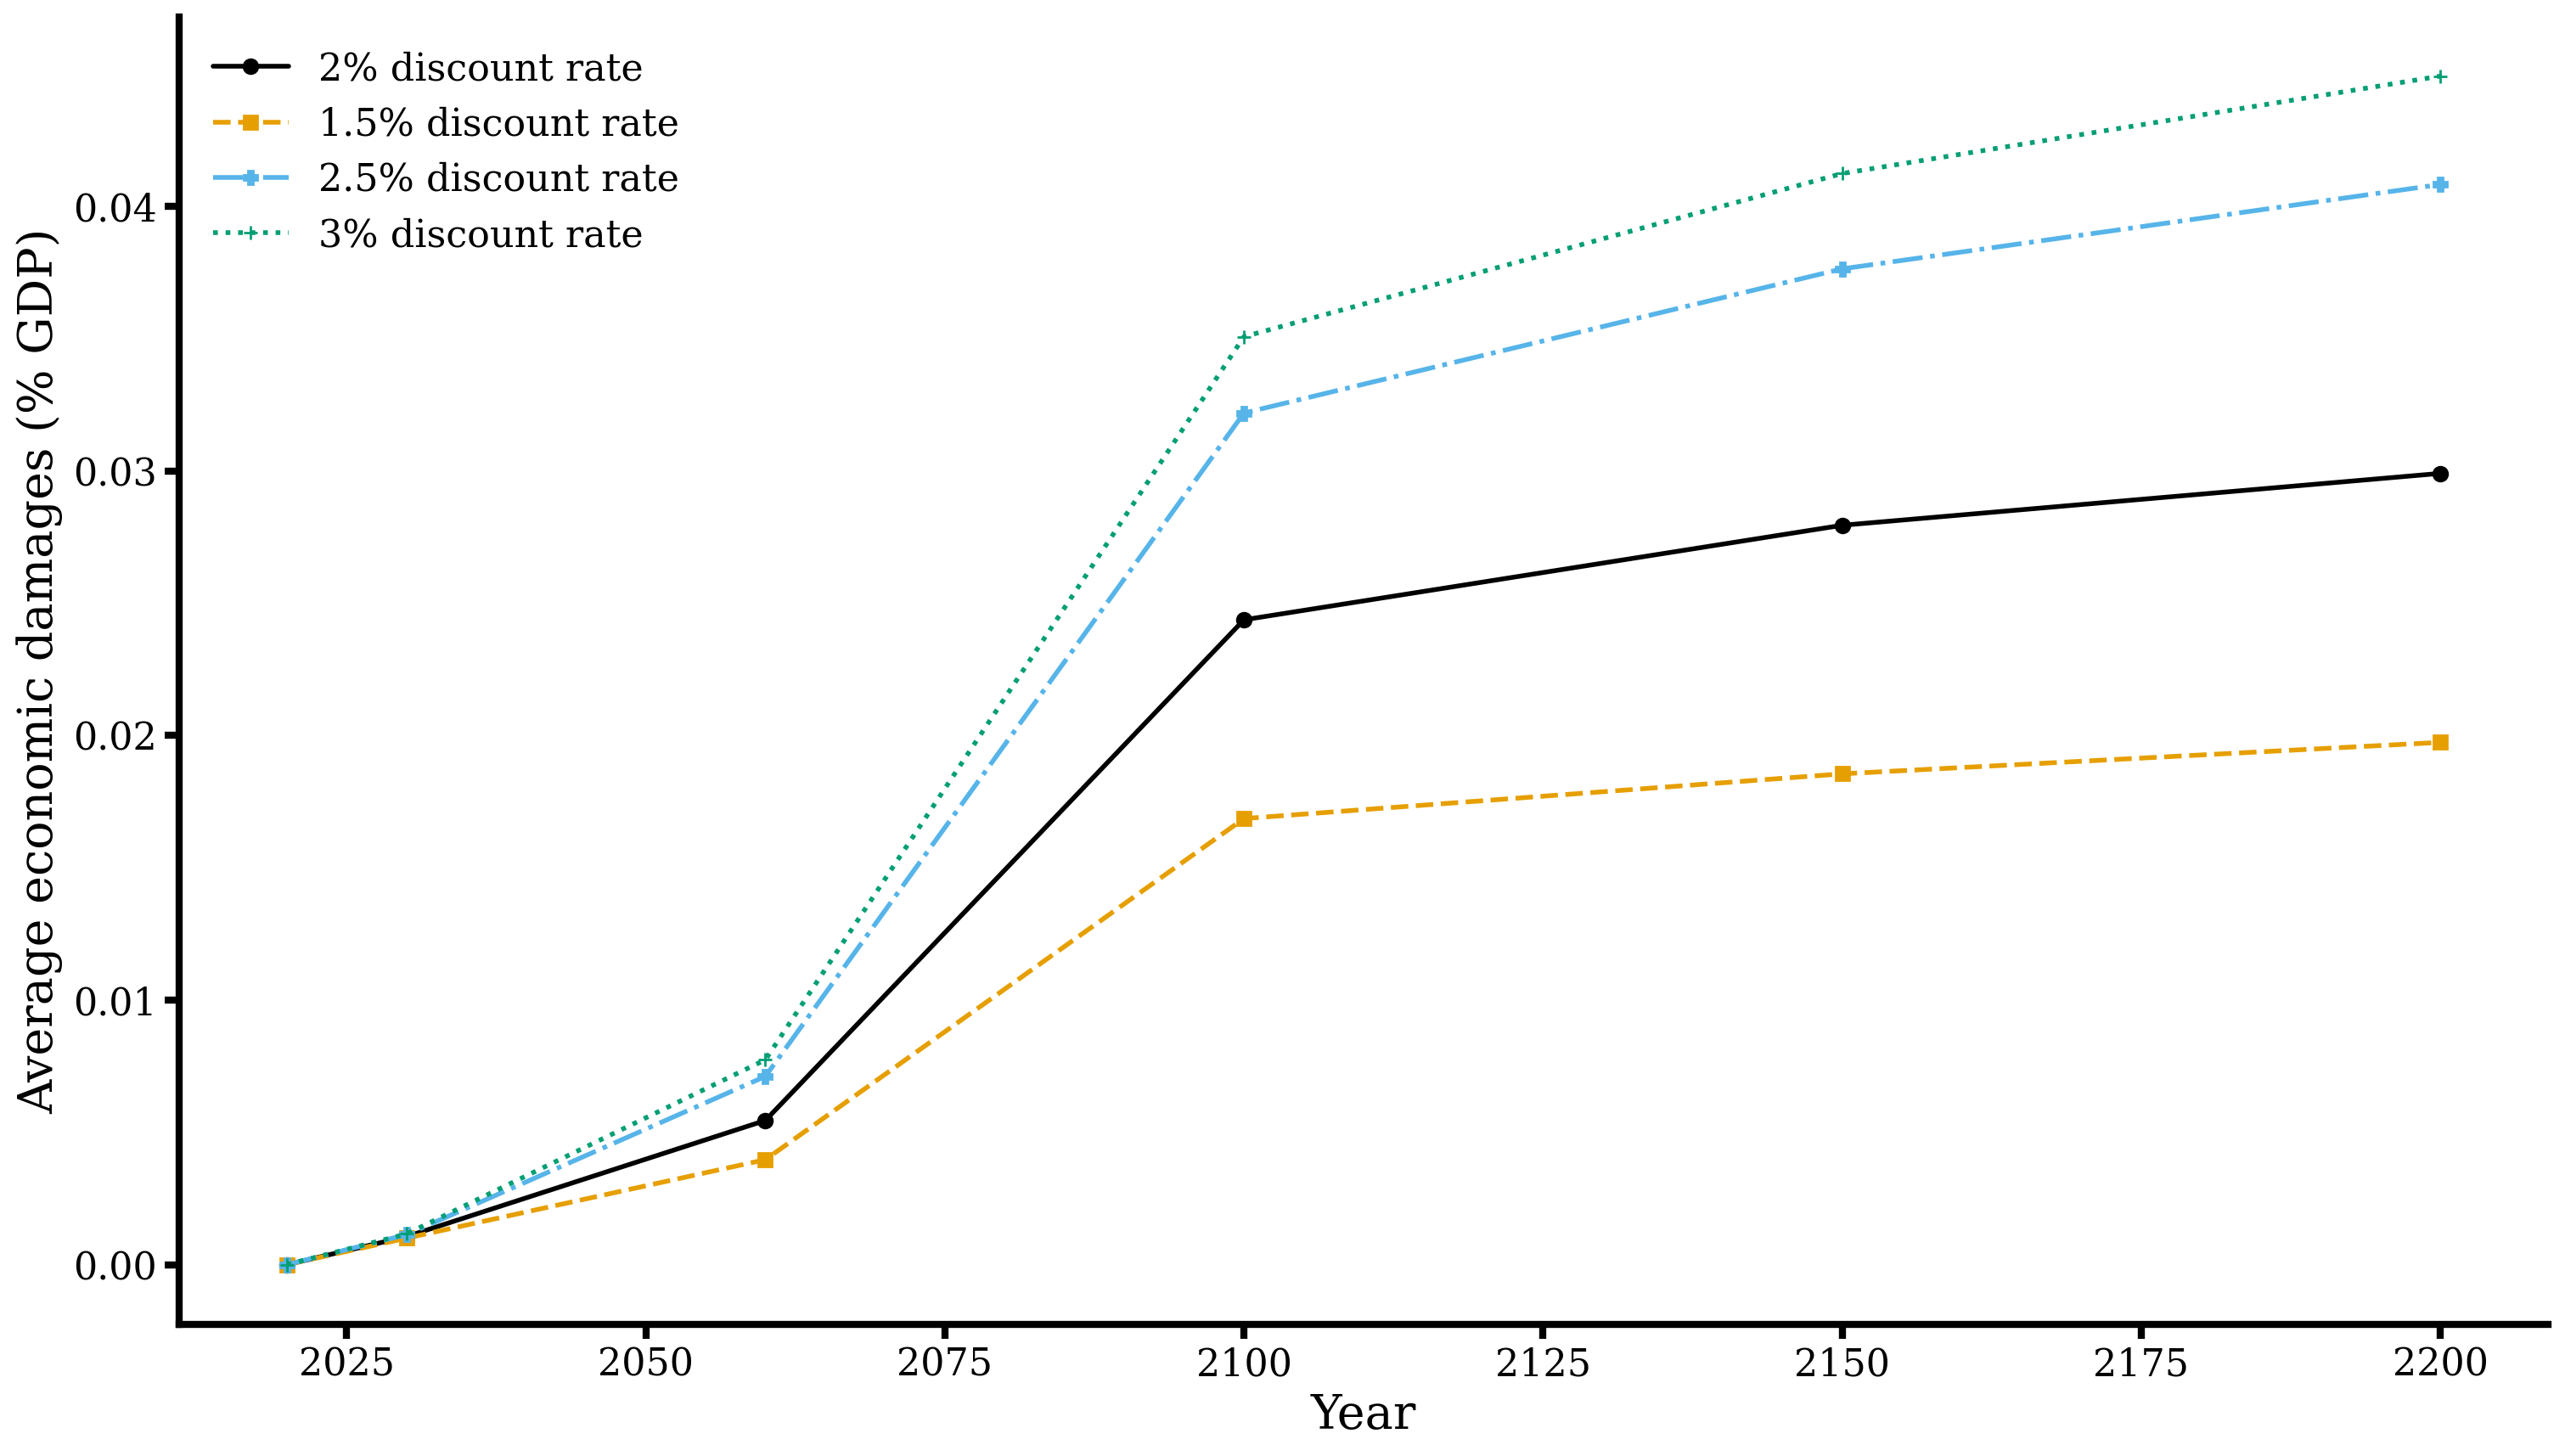

In [18]:
fig, ax = plt.subplots()

for file in range(0, N_files):
    ax.plot(node_times, np.mean(pickle_obj_list[file].econ_dam_path, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average economic damages (% GDP)")
ax.legend()
ax.set_xlabel(x_label)


Text(0.5, 0, 'Temperature (K)')

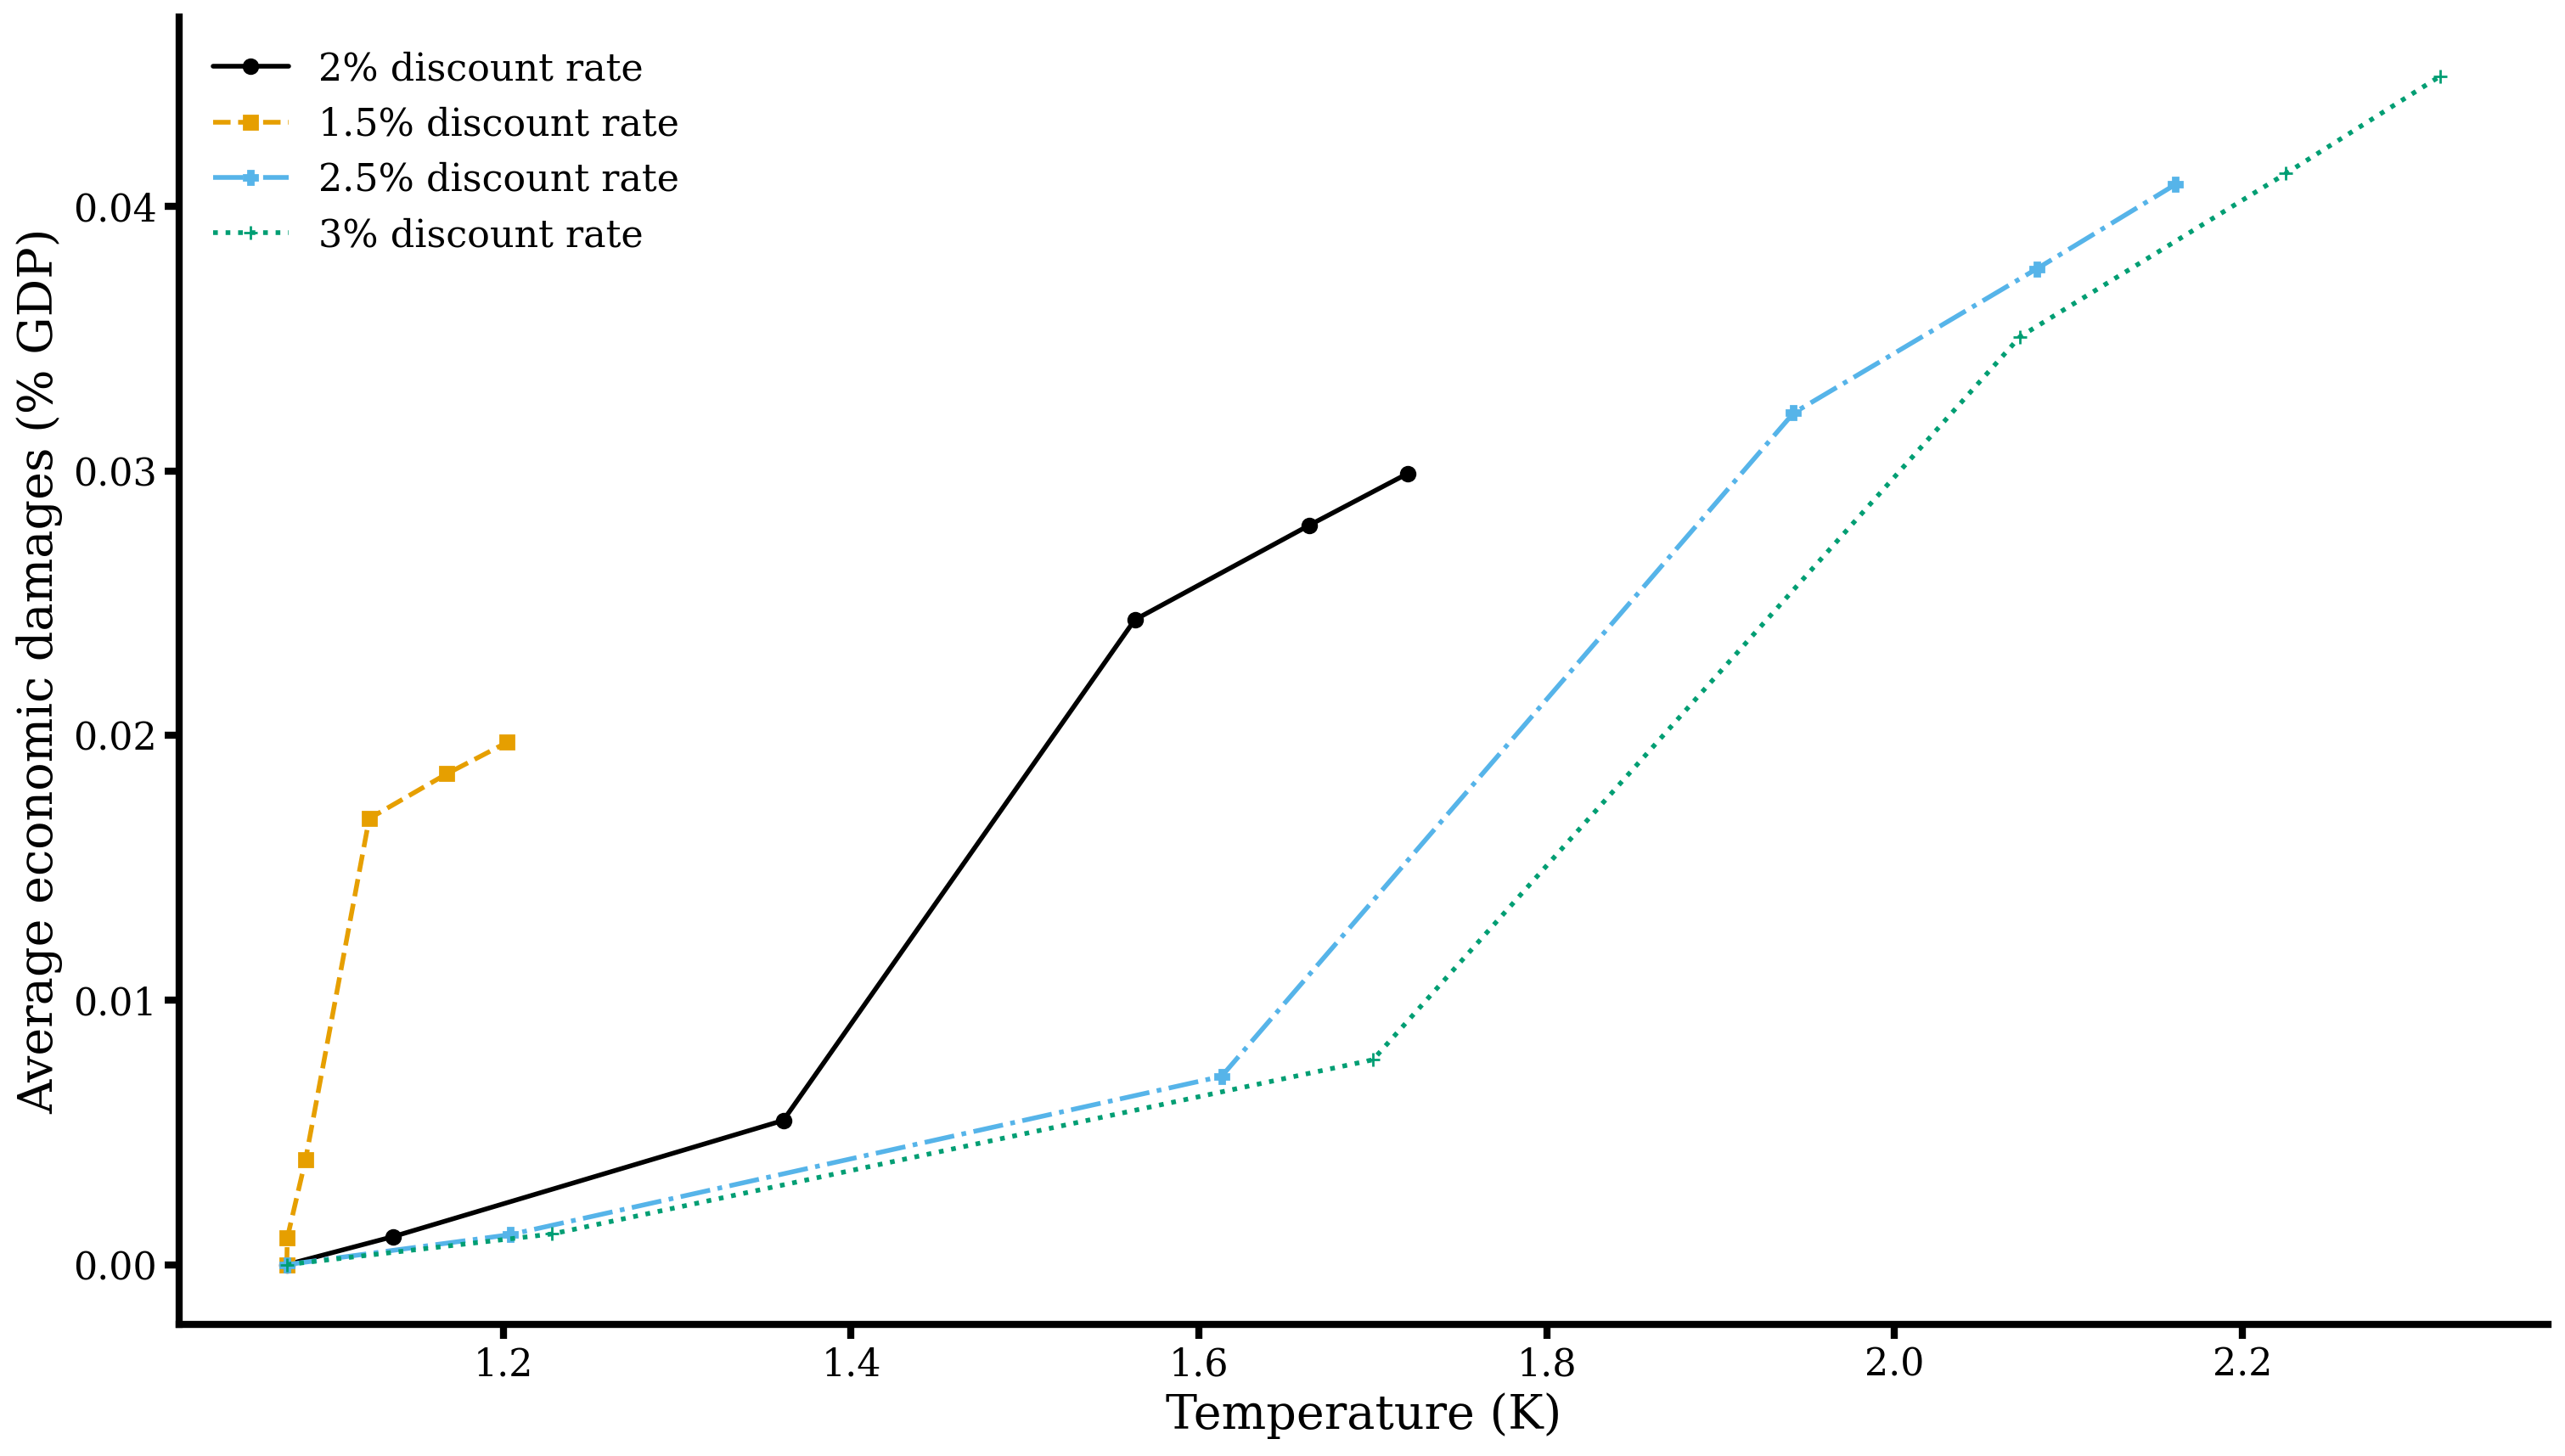

In [19]:
fig, ax = plt.subplots()

for file in range(0, N_files):
    ax.plot(np.mean(pickle_obj_list[file].temp_path, axis=0), np.mean(pickle_obj_list[file].econ_dam_path, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description, markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average economic damages (% GDP)")
ax.legend()
ax.set_xlabel("Temperature (K)")

## 4 Panels -- Figure 2 in Paper (for runs 275, 276, 277, 278)

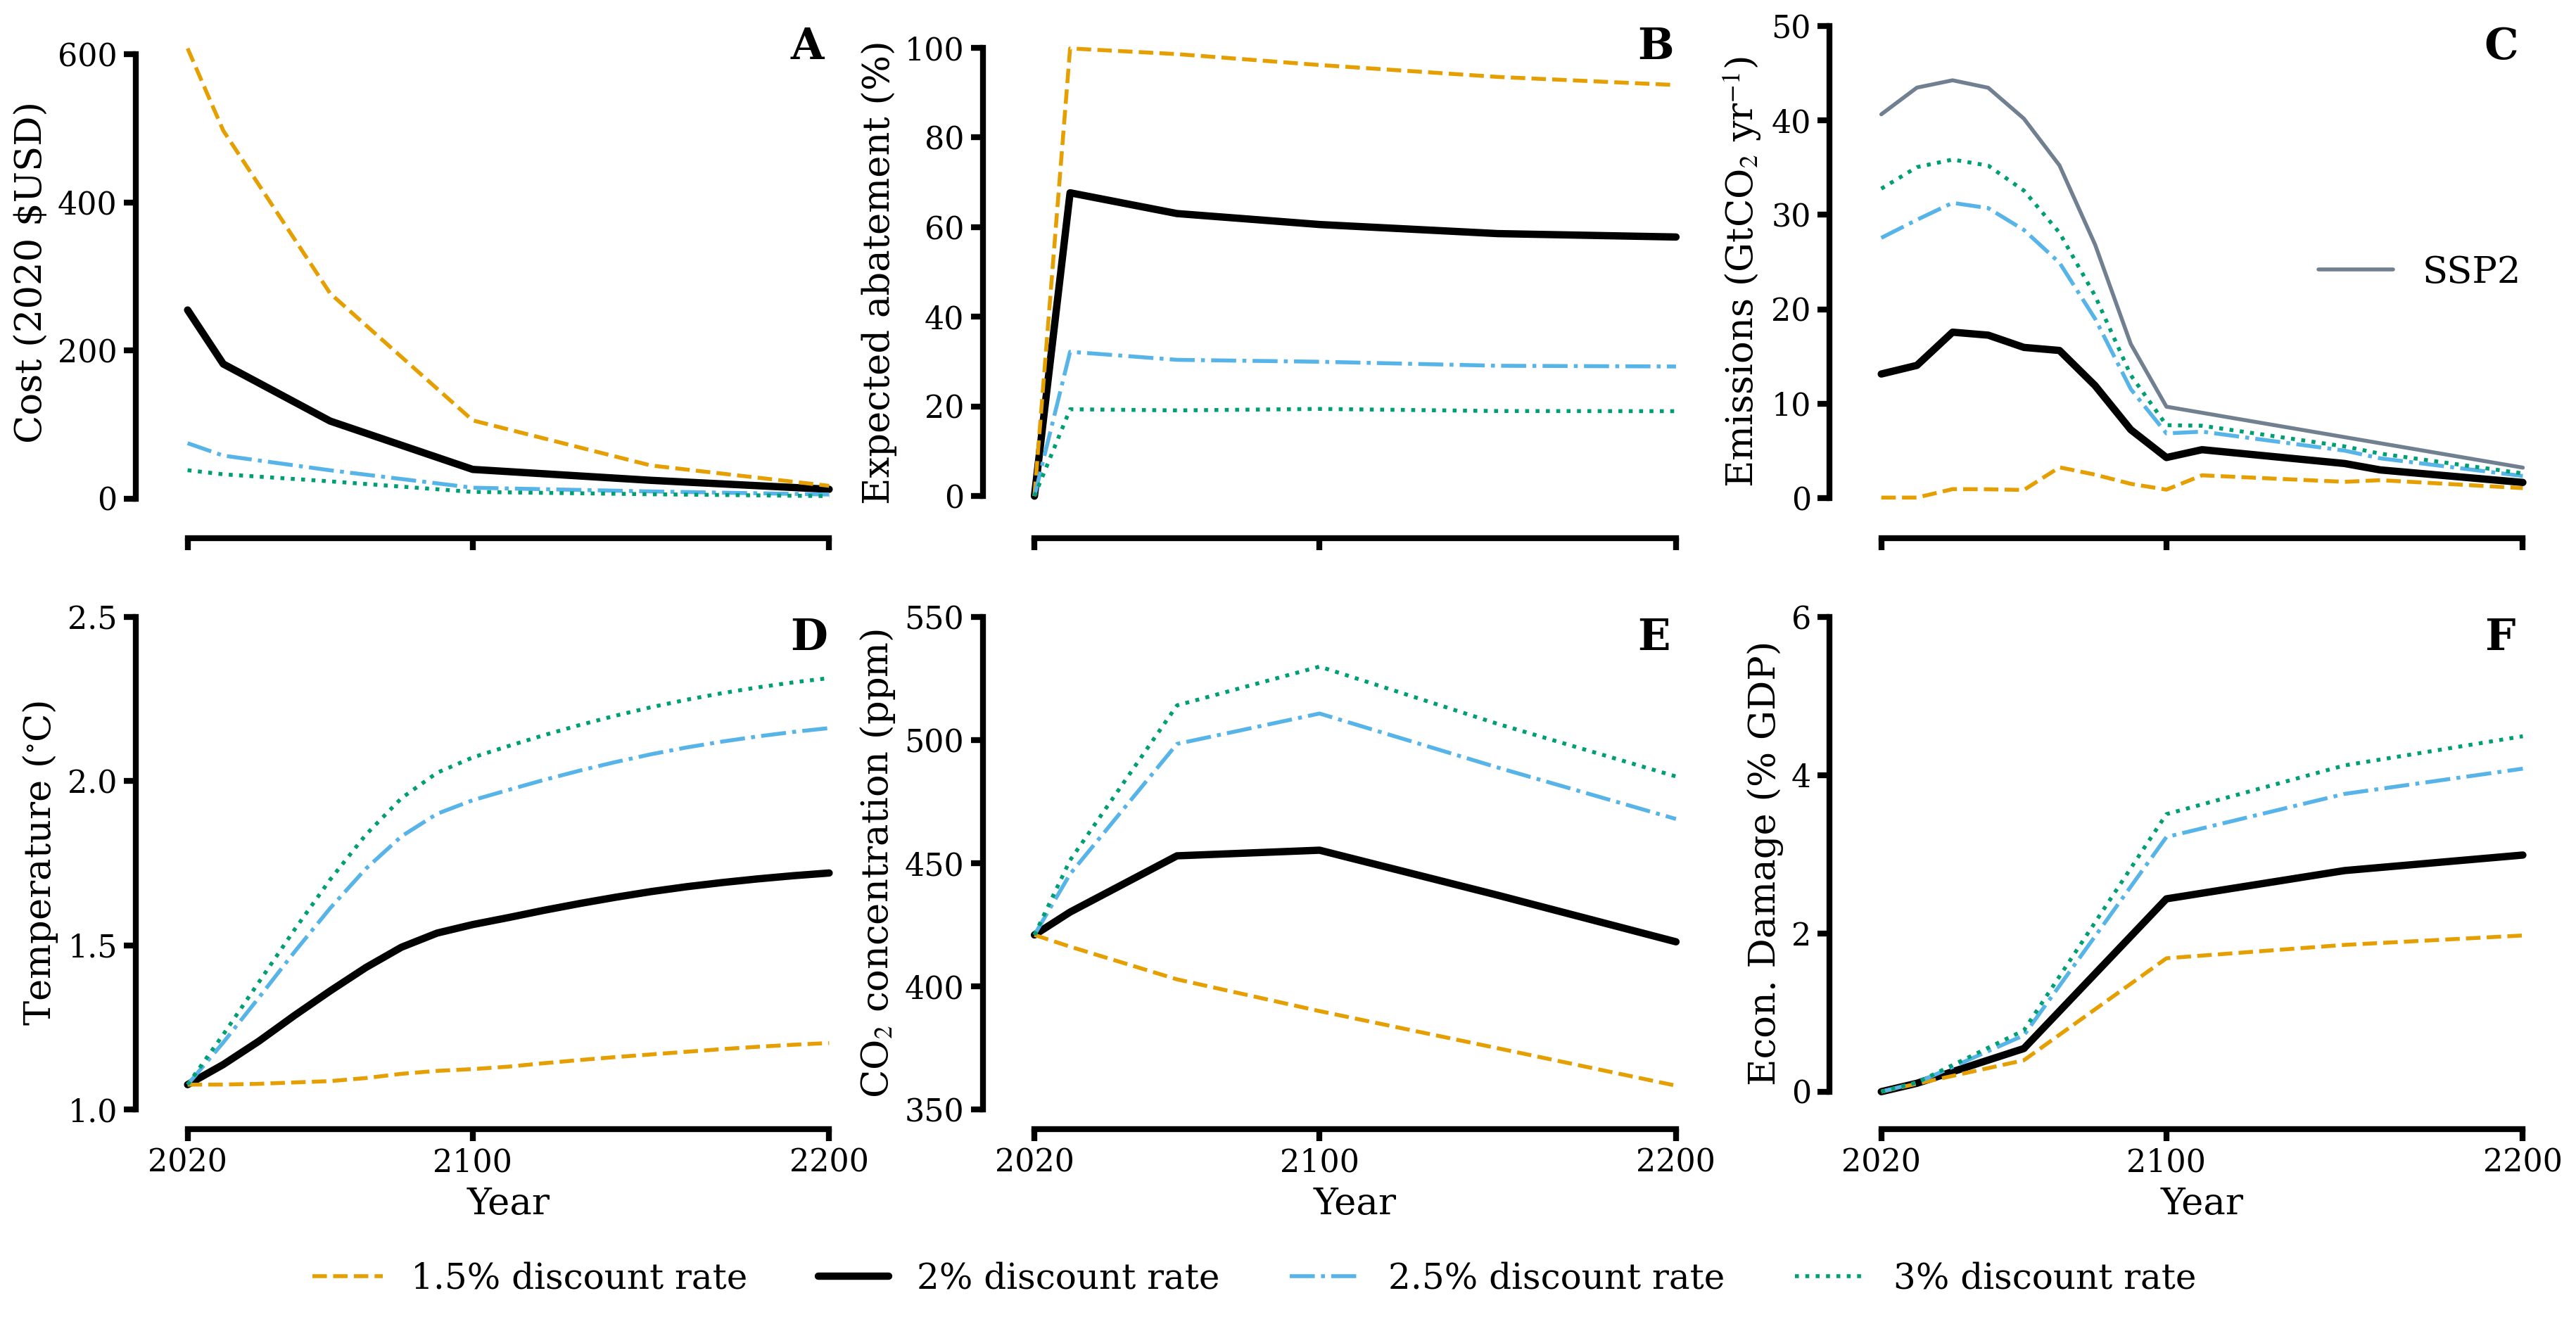

In [32]:
import matplotlib.transforms as mtransforms

fig, ax = plt.subplot_mosaic([['A', 'B', 'C'], ['D', 'E', 'F']], sharex=True,
                             gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1, 1]},
                            figsize=(22,10))

pref_lw = 3.75
feat_lw = 2
pref, = ax['A'].plot(node_times, np.mean(output_obj_list[0].price_path, axis=0), 
              color=color_list[0], 
              label=pickle_obj_list[0].description,
              linestyle=linestyle_list[0], linewidth=pref_lw)
feat15, = ax['A'].plot(node_times, np.mean(output_obj_list[1].price_path, axis=0), 
              color=color_list[1], 
              label=pickle_obj_list[1].description,
              linestyle=linestyle_list[1], linewidth=linewidth)
feat25, = ax['A'].plot(node_times, np.mean(output_obj_list[2].price_path, axis=0), 
              color=color_list[2], 
              label=pickle_obj_list[2].description,
              linestyle=linestyle_list[2], linewidth=linewidth)
feat3, = ax['A'].plot(node_times, np.mean(output_obj_list[3].price_path, axis=0), 
              color=color_list[3], 
              label=pickle_obj_list[3].description,
              linestyle=linestyle_list[3], linewidth=linewidth)

#ax['B'].hlines(1.5, 2020, 2200, alpha=0.5, color='grey', linestyle='dashed', linewidth=1.75)
#ax['B'].vlines(2100, 1, 2, alpha=0.5, color='grey', linestyle='dashed', linewidth=1.75)

# other plots
for file in range(0, N_files):
    if file == 0:
        ax['B'].plot(node_times, np.mean(output_obj_list[file].exp_mit_path, axis=0) * 100, 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=pref_lw)
        
        ax['C'].plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].emis_gtco2_full, axis=0), 
                      color=color_list[file], 
                      linestyle=linestyle_list[file], linewidth=pref_lw)
        
        ax['D'].plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].temp_full, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=pref_lw)

        ax['E'].plot(node_times, np.mean(output_obj_list[file].ghg_lvl_path, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=pref_lw)

        ax['F'].plot(node_times, np.mean(pickle_obj_list[file].econ_dam_path * 100, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=pref_lw)
        
    else:
        ax['B'].plot(node_times, np.mean(output_obj_list[file].exp_mit_path, axis=0) * 100, 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=feat_lw)
        
        ax['C'].plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].emis_gtco2_full, axis=0), 
                      color=color_list[file], 
                      linestyle=linestyle_list[file], linewidth=feat_lw)
        
        ax['D'].plot(tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[file].temp_full, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=feat_lw)

        ax['E'].plot(node_times, np.mean(output_obj_list[file].ghg_lvl_path, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=feat_lw)

        ax['F'].plot(node_times, np.mean(pickle_obj_list[file].econ_dam_path * 100, axis=0), 
                      color=color_list[file], 
                      label=pickle_obj_list[file].description,
                      linestyle=linestyle_list[file], linewidth=feat_lw)
        
        
# plot SSP2 for clarity
ax['C'].plot(tmp_baseline_emission_model.times[:-5], tmp_baseline_emission_model.baseline_gtco2[:-5], 
        color='slategrey', label="SSP2", linewidth=feat_lw)
ax['C'].legend(loc='right', fontsize=19)

panels = ['A', 'B', 'C', 'D', 'E', 'F']
for panel in panels:
    ax[panel].set_xticks([2020, 2100, 2200])

# set ticks
ax['A'].set_yticks([0, 200, 400, 600])
ax['B'].set_yticks([0, 20, 40, 60, 80, 100])
ax['C'].set_yticks([0, 10, 20, 30, 40, 50])
ax['D'].set_yticks([1, 1.5, 2, 2.5])
ax['E'].set_yticks([350, 400, 450, 500, 550])
ax['F'].set_yticks([0, 2, 4, 6])

# set labels
ax['A'].set_ylabel("Cost (2020 $USD)", fontsize=19)
ax['B'].set_ylabel("Expected abatement (%)", fontsize=19)
ax['C'].set_ylabel("Emissions (GtCO$_2$ yr$^{-1}$)", fontsize=19)
ax['D'].set_ylabel("Temperature ($^{\circ}$C)", fontsize=19)
ax['E'].set_ylabel("CO$_2$ concentration (ppm)", fontsize=19)
ax['F'].set_ylabel("Econ. Damage (% GDP)", fontsize=19)

ax['D'].set_xlabel("Year", fontsize=19)
ax['E'].set_xlabel("Year", fontsize=19)
ax['F'].set_xlabel("Year", fontsize=19)
#ax['A'].set_ylim((0,310))

# bottom legend
fig.legend([feat15, pref, feat25, feat3], ["1.5% discount rate", "2% discount rate", "2.5% discount rate", "3% discount rate"], 
           bbox_to_anchor=(0.48, -0.045), 
           loc='lower center', ncol=4, fancybox=True, shadow=True, fontsize=18)

# add labels
right = ['A', 'B', 'C', 'D', 'E', 'F']
for label in right:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(0, 0.0, fig.dpi_scale_trans)
    ax[label].text(0.9, 1.0, label, transform=ax[label].transAxes + trans, fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='none', pad=1))
    
sns.despine(trim=True, offset=10)

#fig.savefig(''.join([basefile, 'pref-runs-NFL.png']),bbox_inches='tight', dpi=400)

In [25]:
for i in range(len(pickle_obj_list)):
    print(np.mean(pickle_obj_list[i].econ_dam_path, axis=0) * 100)

[0.         0.10598185 0.54504192 2.43734835 2.79466942 2.99079643]
[0.         0.10008353 0.39685133 1.68605041 1.85517516 1.97409089]
[0.         0.11324343 0.71160562 3.218882   3.76389987 4.08274479]
[0.         0.11597473 0.77436316 3.50745292 4.12422585 4.49252935]


In [30]:
for i in range(len(pickle_obj_list)):
    print(np.mean(pickle_obj_list[i].temp_full, axis=0)[0], 
         np.mean(pickle_obj_list[i].temp_full, axis=0)[1],
         np.mean(pickle_obj_list[i].temp_full, axis=0)[4],
         np.mean(pickle_obj_list[i].temp_full, axis=0)[8],
         np.mean(pickle_obj_list[i].temp_full, axis=0)[13],
         np.mean(pickle_obj_list[i].temp_full, axis=0)[18])

1.0755000114440918 1.1367043256759644 1.3609881401062012 1.5631248354911804 1.6634544879198074 1.7201839536428452
1.0755000114440918 1.0757372379302979 1.0862717628479004 1.1228743493556976 1.1675212979316711 1.2022613137960434
1.0755000114440918 1.203835368156433 1.6129964590072632 1.941924899816513 2.0817656368017197 2.1615277156233788
1.0755000114440918 1.2281053066253662 1.700093150138855 2.072158247232437 2.2250467240810394 2.313862532377243


In [27]:
tmp_baseline_emission_model.times[:-5], np.mean(pickle_obj_list[0].emis_gtco2_full, axis=0)

(array([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120,
        2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200]),
 array([13.1436348 , 14.05825806, 17.57244062, 17.25845671, 15.96167374,
        15.63607574, 11.90979588,  7.2441119 ,  4.2968654 ,  5.1283403 ,
         4.76203033,  4.39572033,  4.02941033,  3.66310029,  2.98384656,
         2.652308  ,  2.3207695 ,  1.98923102,  1.65769252]))